In [ ]:
Trades-Results

In [93]:
# import libs
%matplotlib inline
import psycopg2
from config import config
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import pandas as pd
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.display import clear_output

In [94]:
# set some pandas plotting params
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [95]:
# open connection to timescale-db
conn = None

# read connection parameters
params = config()

# connect to the PostgreSQL server
conn = psycopg2.connect(**params)

In [96]:
# define a query string
query = """
    SELECT
    time_bucket_gapfill('{time_bucket_size}', timestamp, start => '{from_timestamp}', finish => '{to_timestamp}') as time,
    locf(last(price, timestamp)) as {price_column_name}
    FROM {table_name}
    WHERE timestamp >= '{from_timestamp}' AND timestamp <= '{to_timestamp}'
    GROUP BY time
"""

# define additional infos about database
currencies = [
    {'price_column_name':'btc_kraken',   'table_name':'trades_kraken_xbtusd',    'name': 'Bitcoin Kraken'},
    {'price_column_name':'btc_bitfinex', 'table_name':'trades_bitfinex_tbtcusd', 'name': 'Bitcoin Bitfinex'},
    {'price_column_name':'eth_kraken',   'table_name':'trades_kraken_ethusd',    'name': 'Ethereum Kraken'},
    {'price_column_name':'eth_bitfinex', 'table_name':'trades_bitfinex_tethusd', 'name': 'Ethereum Bitfinex'},
    {'price_column_name':'ltc_kraken',   'table_name':'trades_kraken_ltcusd',    'name': 'Litecoin Kraken'},
    {'price_column_name':'ltc_bitfinex', 'table_name':'trades_bitfinex_tltcusd', 'name': 'Litecoin Bitfinex'}
]

In [97]:
# define a getData method for querying the data from database with default values
def getData(time_bucket_size='1 days',from_timestamp='2019-06-01 00:00',to_timestamp='2019-06-29 23:59'):
    query_strings = map(lambda x: query.format(
        time_bucket_size=time_bucket_size,
        price_column_name=x['price_column_name'],
        table_name=x['table_name'],
        from_timestamp=from_timestamp,
        to_timestamp=to_timestamp
    ), currencies)
    
    dfs = map(lambda x: pd.read_sql(x, conn).set_index('time'), query_strings)
        
    result = reduce(lambda left,right: pd.merge(left, right, on='time'), dfs)

    result.rename(columns={
        'btc_kraken':'Bitcoin Kraken',
        'btc_bitfinex':'Bitcoin Bitfinex',
        'eth_kraken':'Ethereum Kraken',
        'eth_bitfinex':'Ethereum Bitfinex',
        'ltc_kraken':'Litecoin Kraken',
        'ltc_bitfinex':'Litecoin Bitfinex'
    }, inplace=True)
    
    return result

In [98]:
# query the actual data and save it temporarily in local variables for faster access
dayData = getData(time_bucket_size='1 days')
hourData = getData(time_bucket_size='1 hours')
minuteData = getData(time_bucket_size='1 minutes')
tenSecondData = getData(time_bucket_size='10 seconds')
fiveSecondData = getData(time_bucket_size='5 seconds')
secondData = getData(time_bucket_size='1 seconds')

In [21]:
# define method for ploting correlation
def plotCorrelation(name, data, method='pearson'):
    f = plt.figure(figsize=(19, 15))
    plt.matshow(data.corr(method=method), fignum=f.number)
    plt.xticks(range(data.shape[1]), data.columns, fontsize=24, rotation=90)
    plt.yticks(range(data.shape[1]), data.columns, fontsize=24)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=24)

In [22]:
# define currency names array with associated data
collectedData = [
    {'name':'1day-data', 'data':dayData},
    {'name':'1hour-data', 'data':hourData},
    {'name':'1minute-data', 'data':minuteData},
    {'name':'10seconds-data', 'data':tenSecondData},
    {'name':'5seconds-data', 'data':fiveSecondData},
    {'name':'1second-data', 'data':secondData},
]

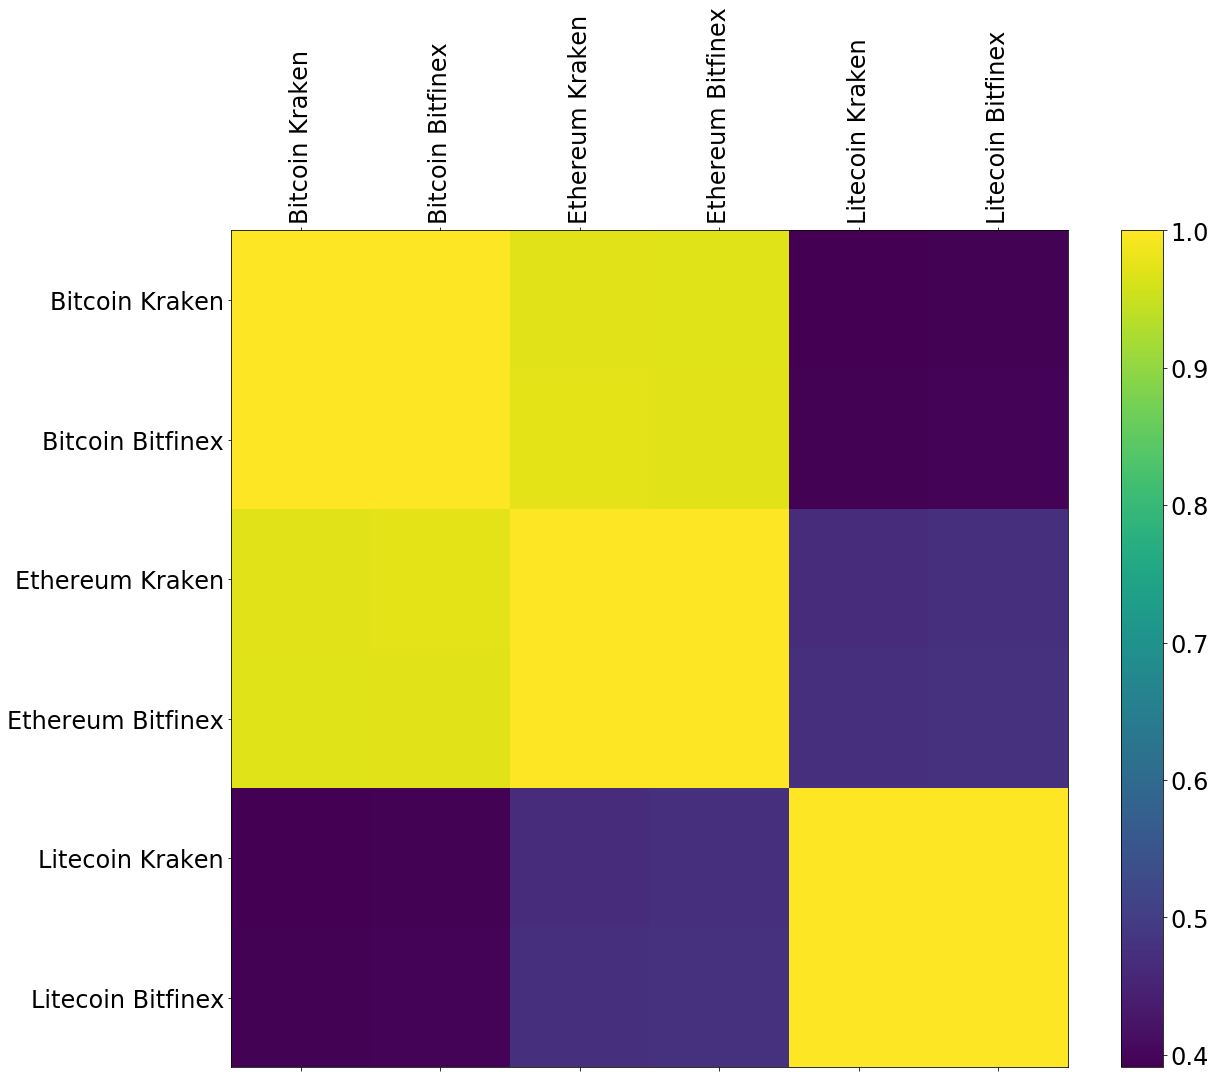

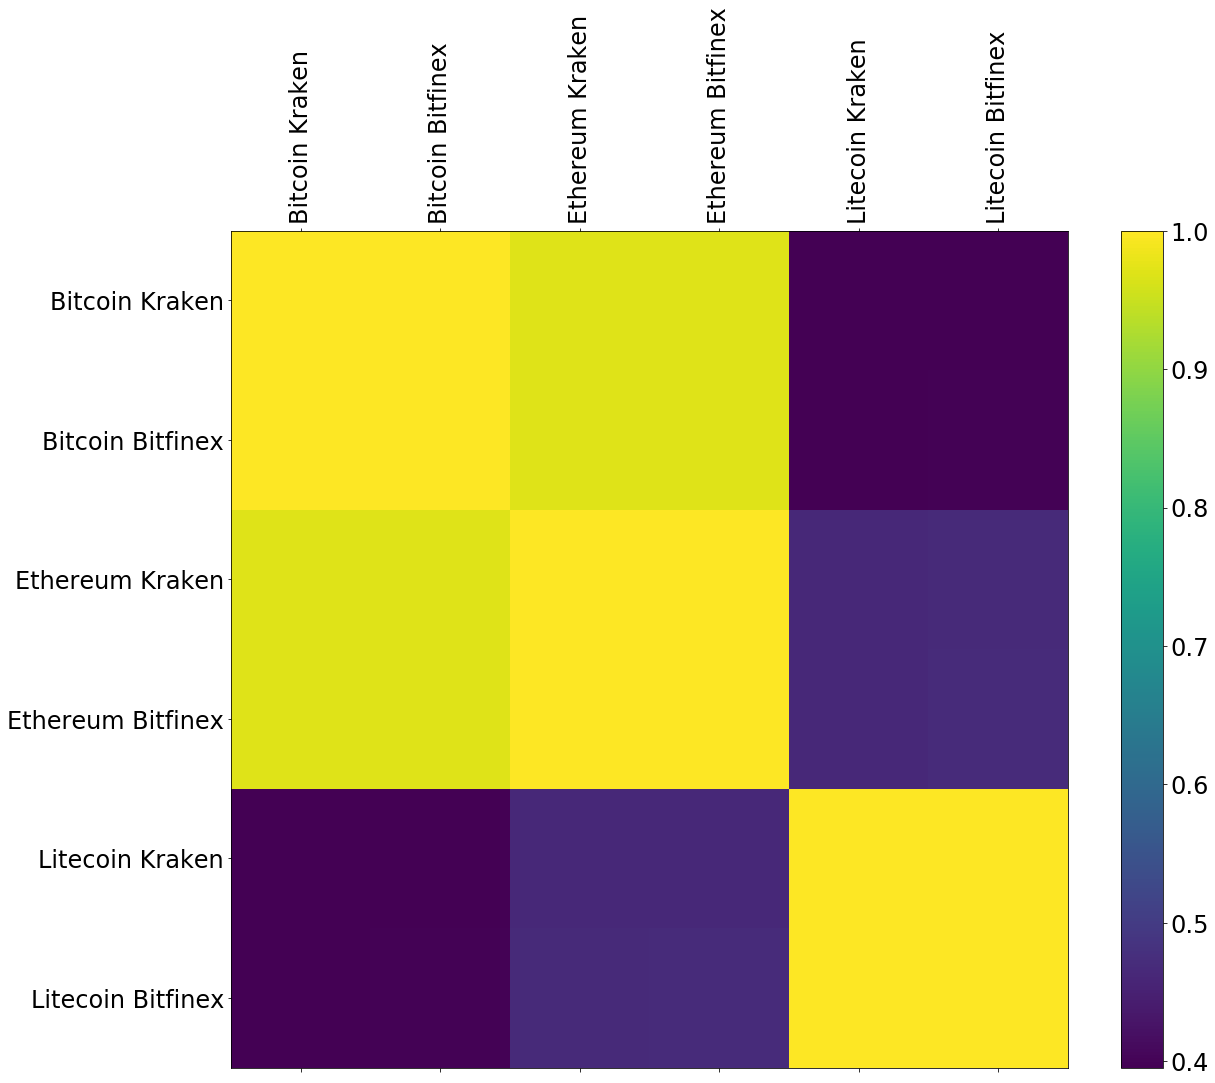

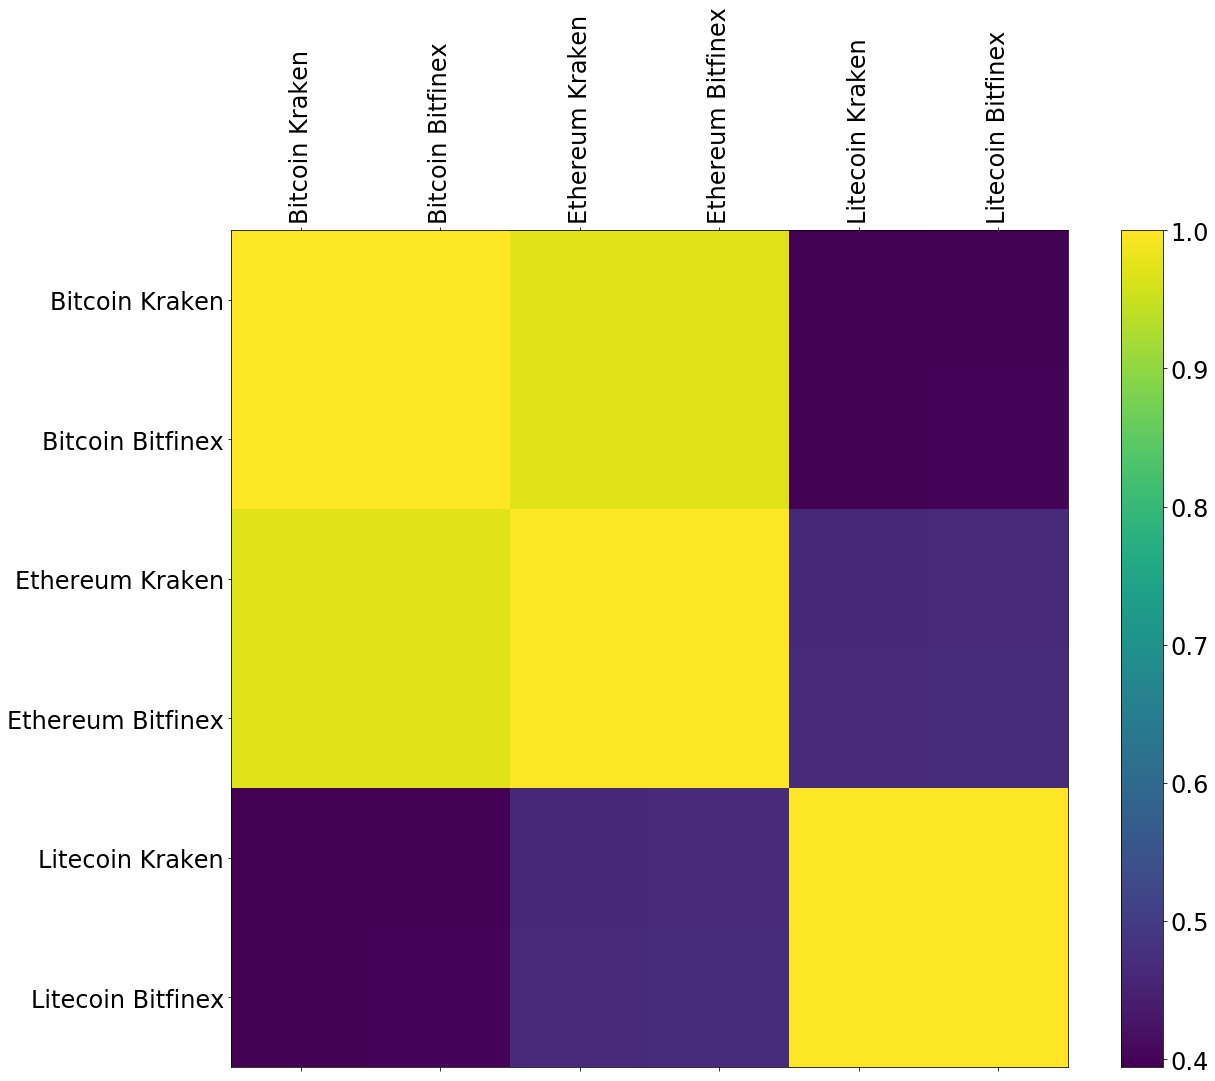

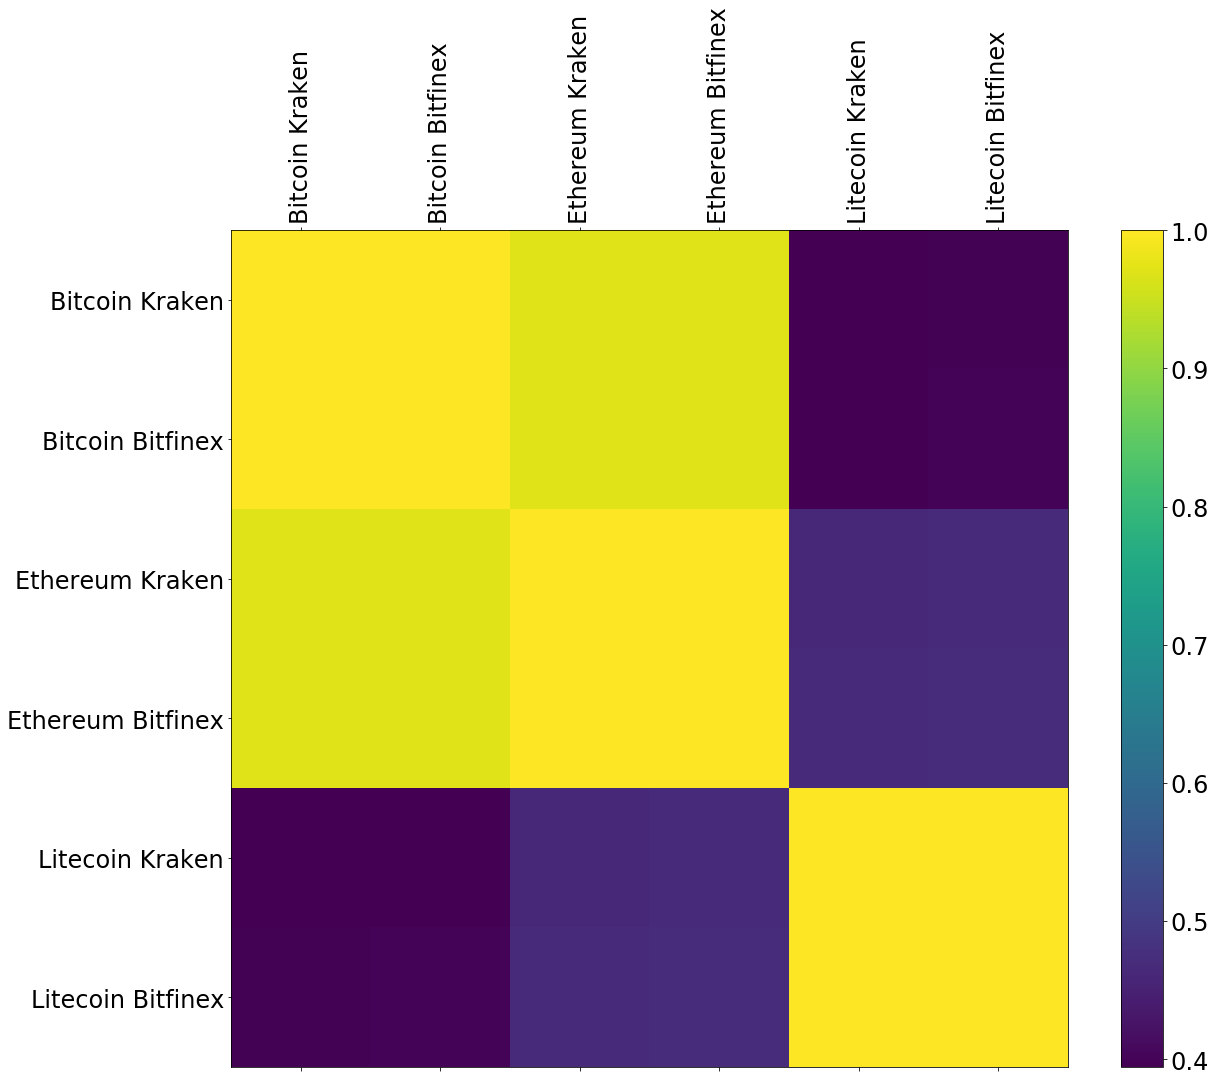

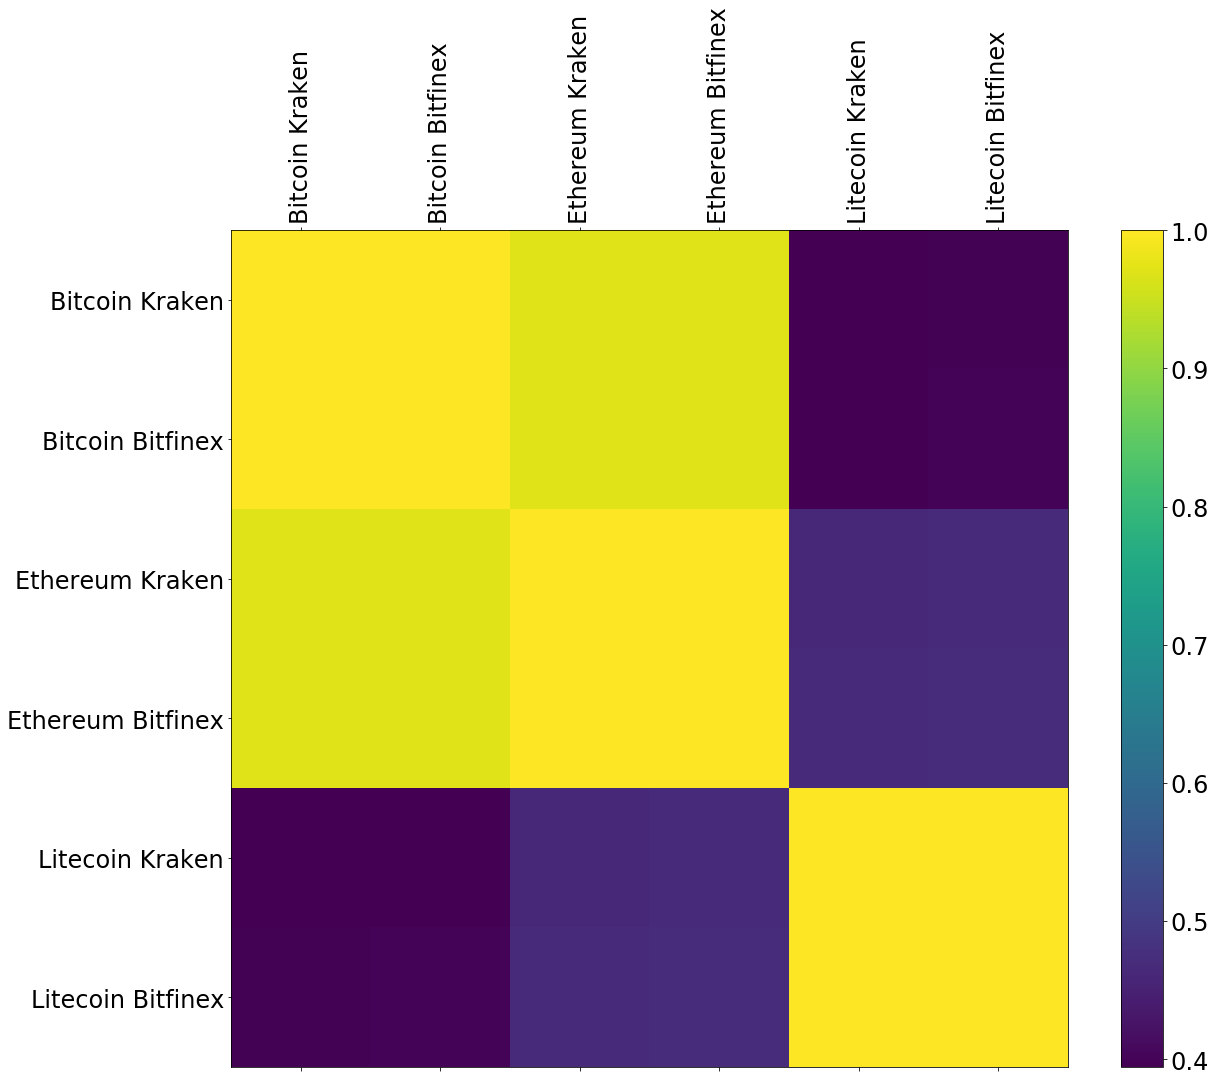

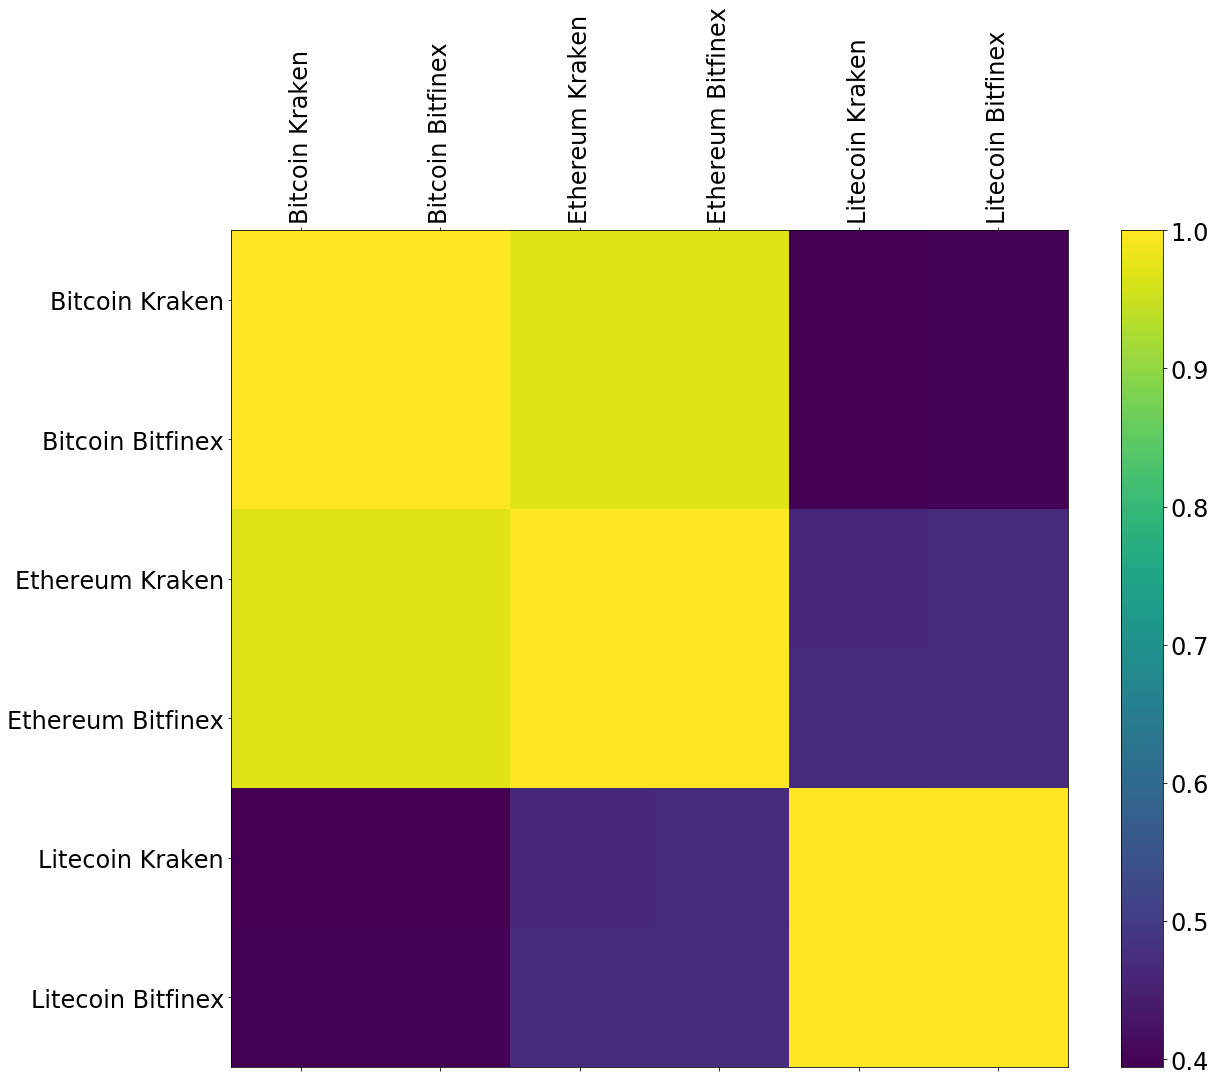

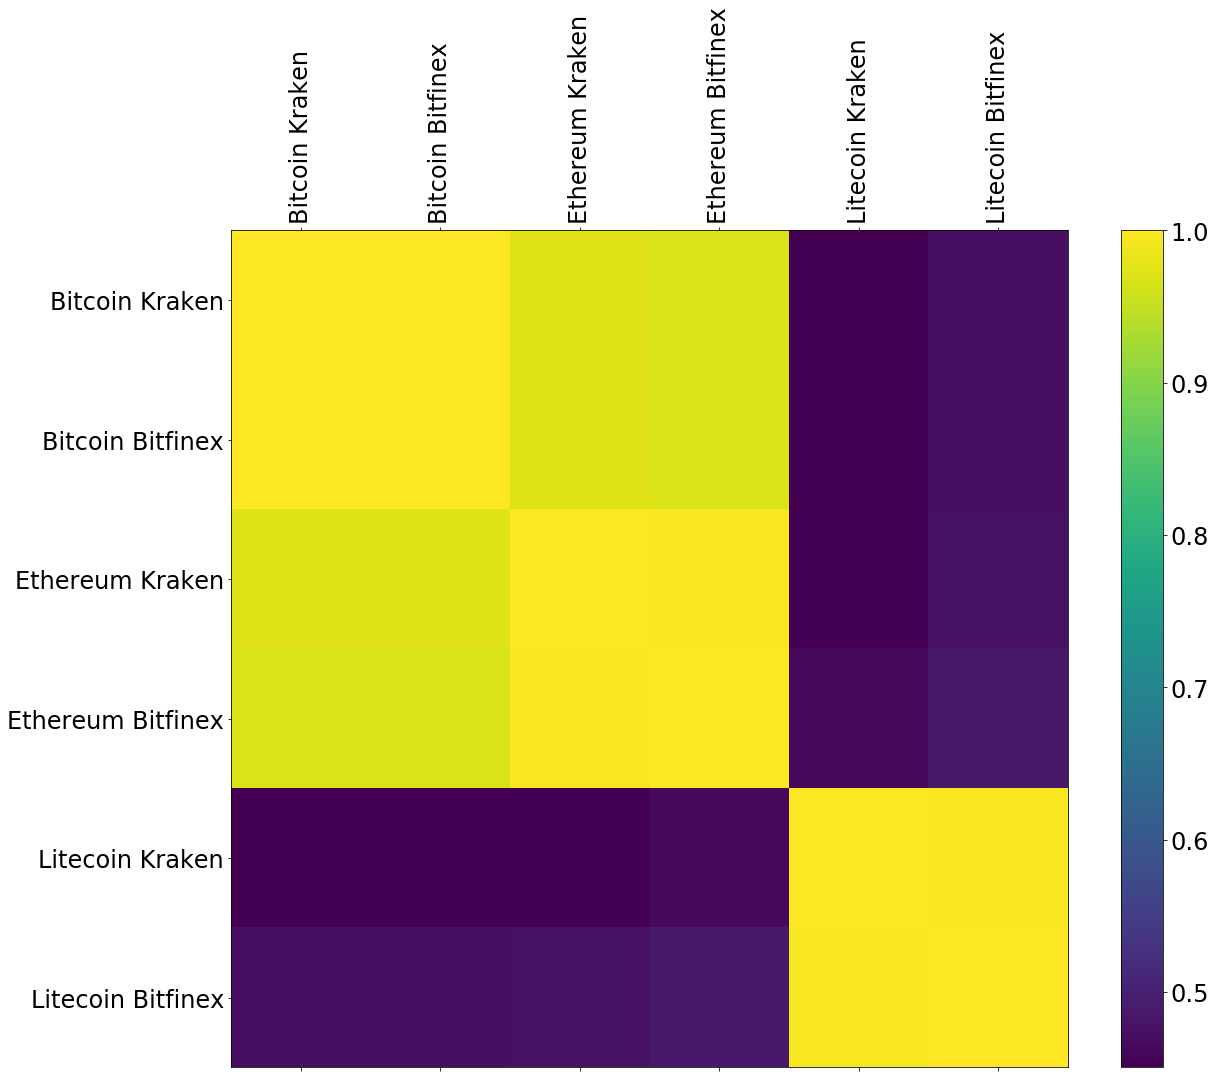

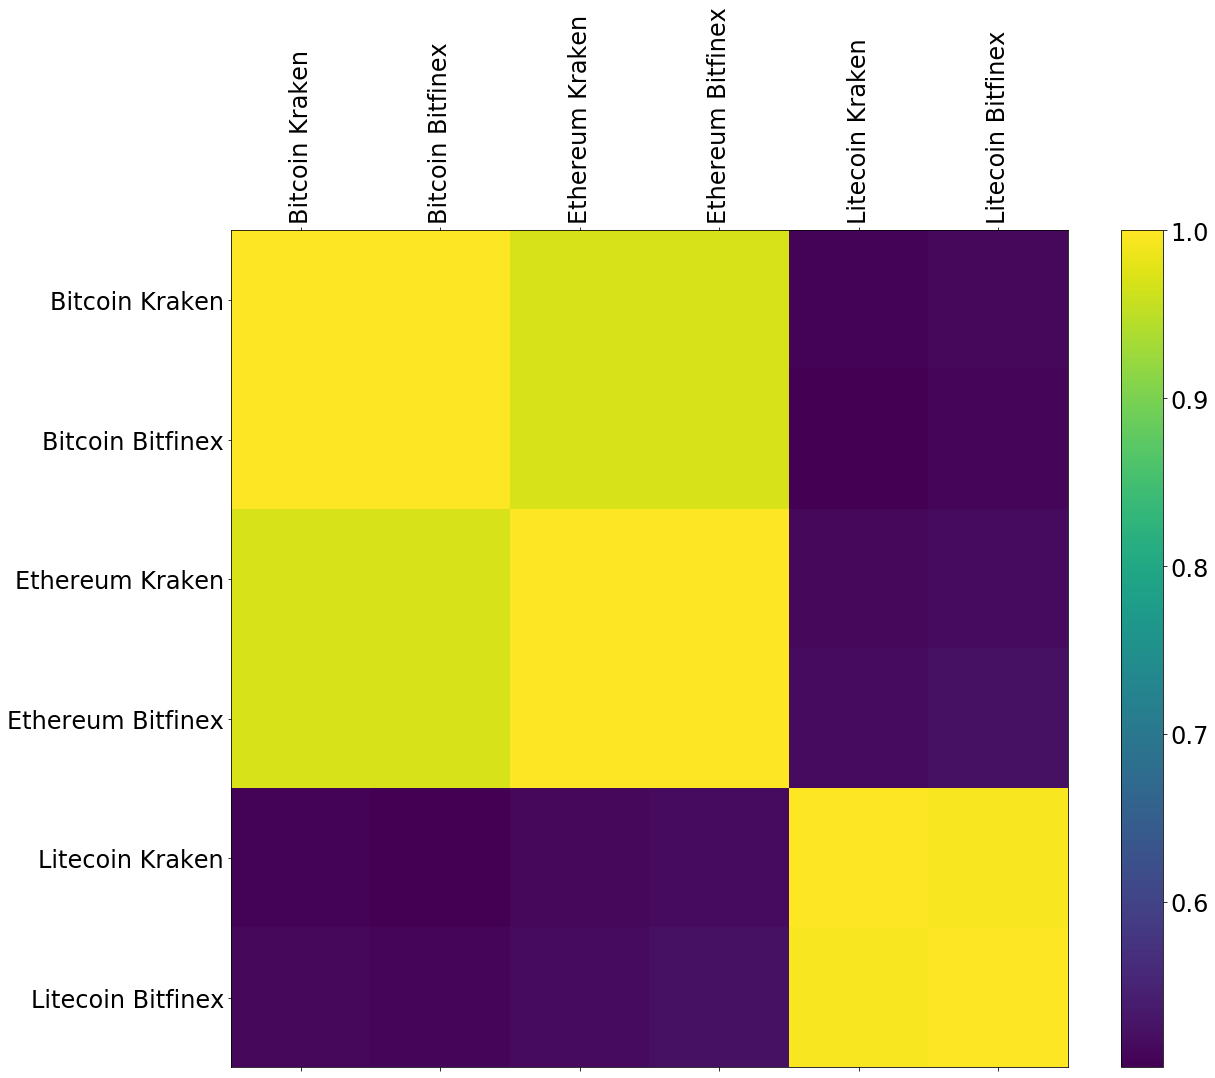

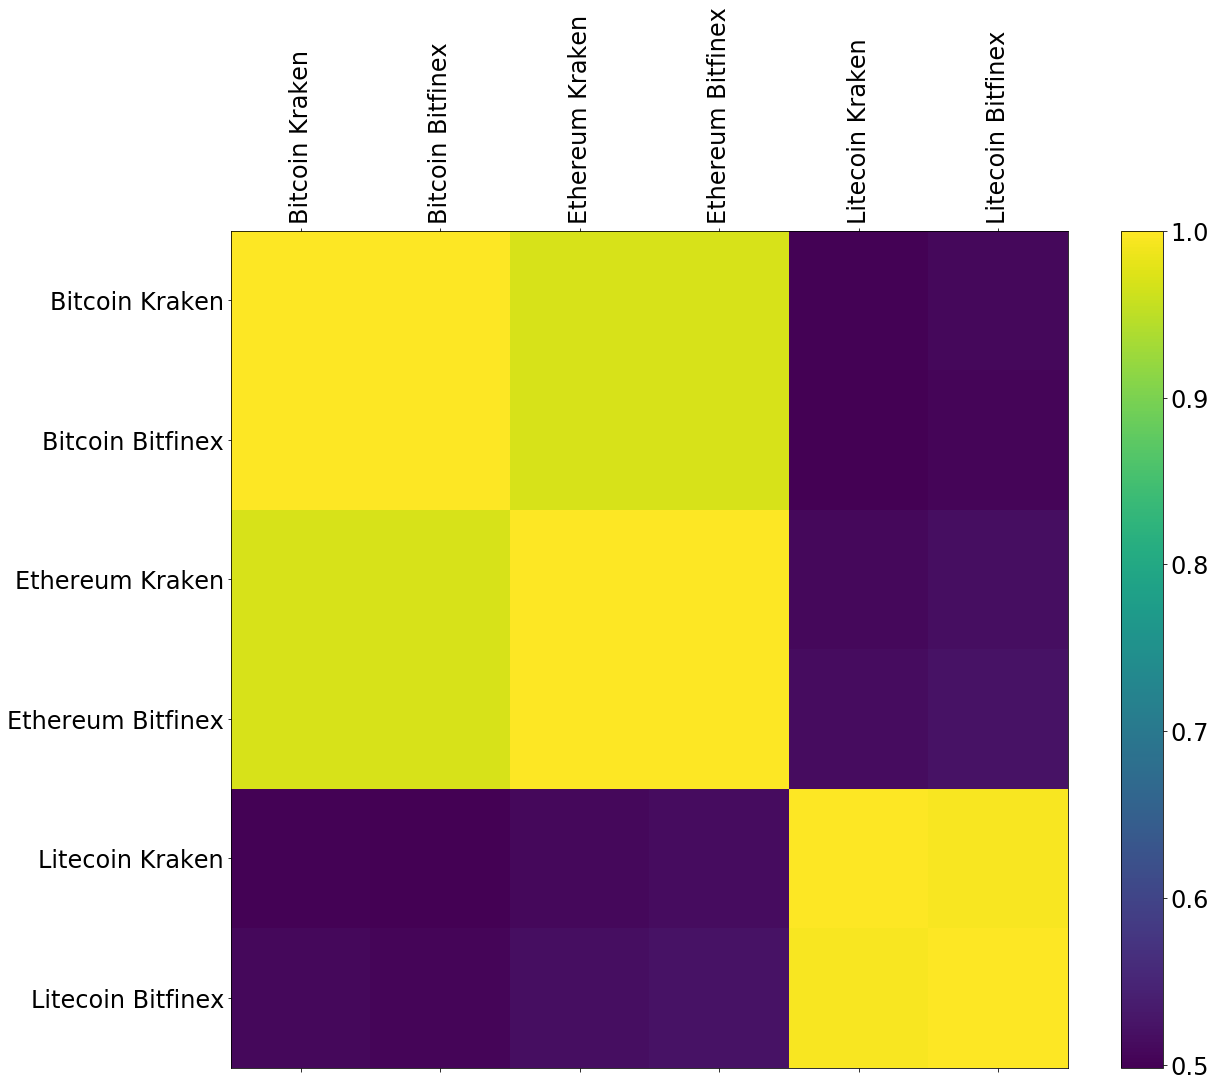

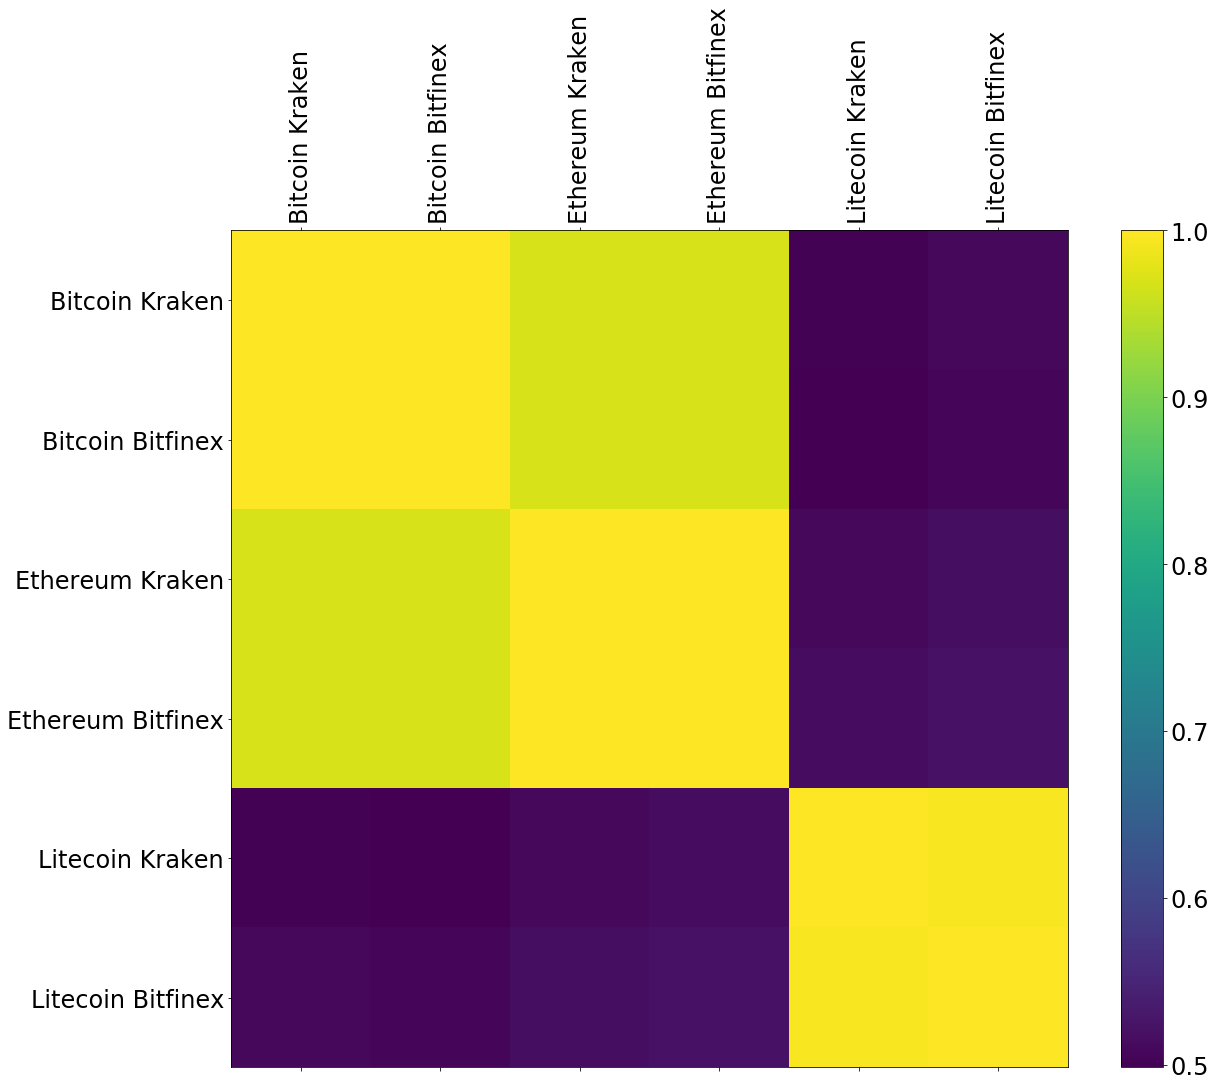

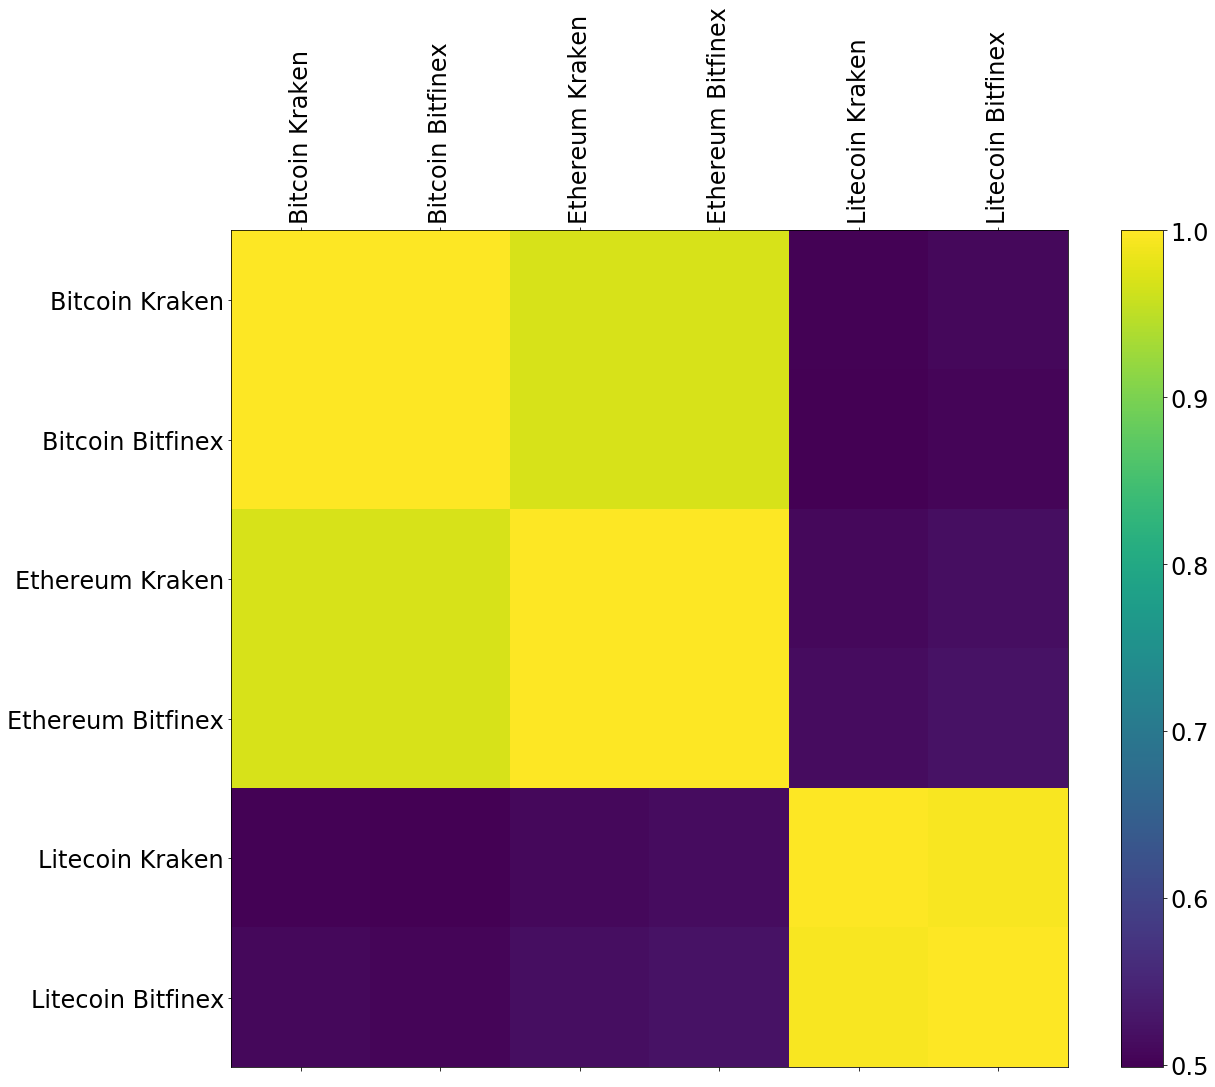

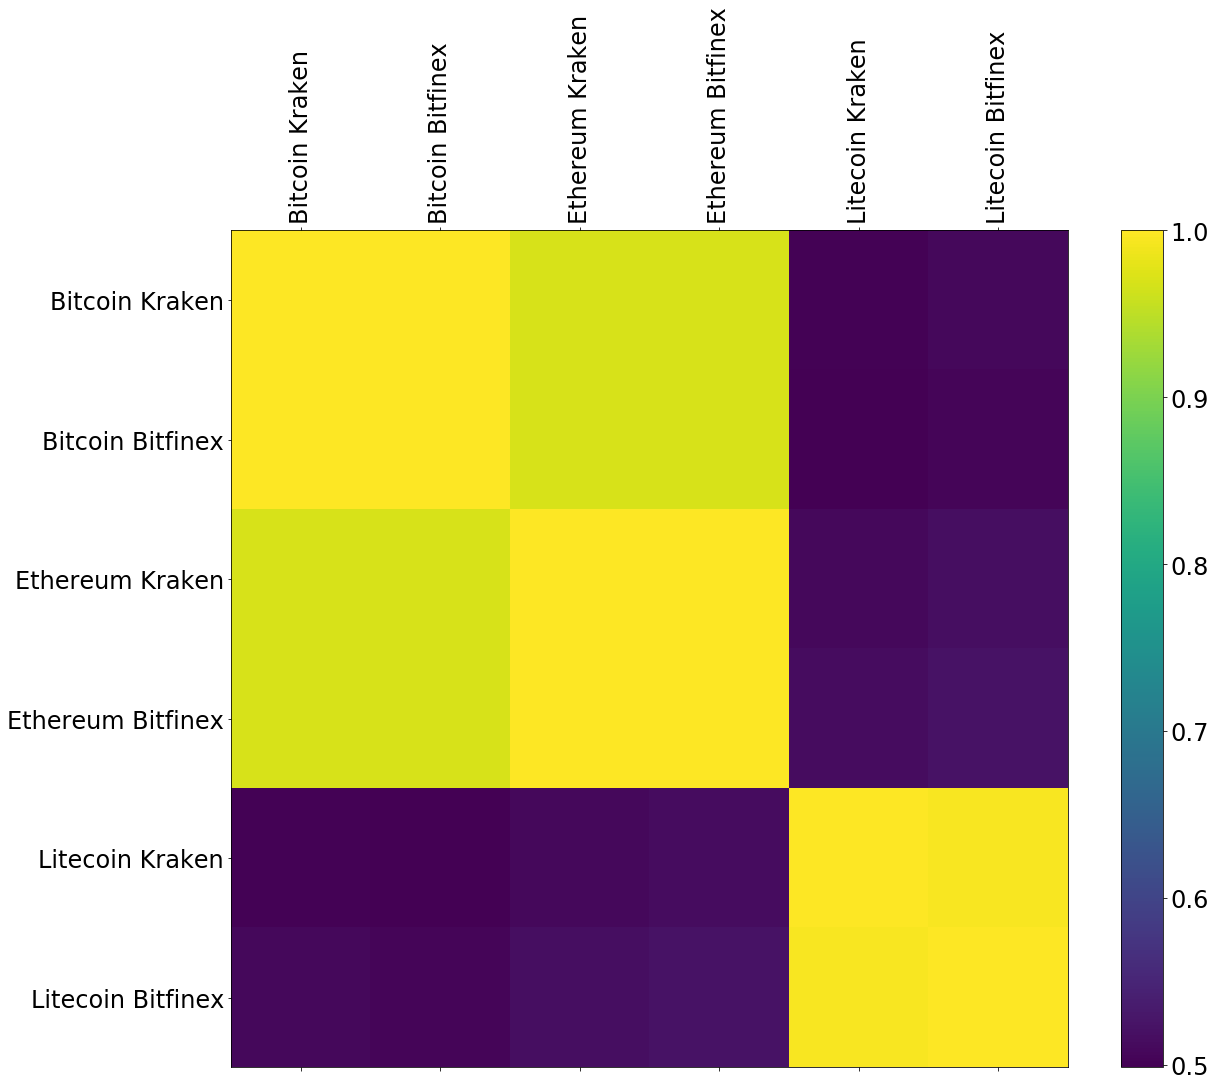

In [23]:
# first, investigate pearson and spearman correlation
# pearson
for collectedDataEntry in collectedData:
    plotCorrelation(collectedDataEntry['name'], collectedDataEntry['data'])
# spearman
for collectedDataEntry in collectedData:
    plotCorrelation(collectedDataEntry['name'], collectedDataEntry['data'], method='spearman')

In [10]:
# define profit and log profit methods
#profit
def profit(data):
    data = (data - data.shift(-1)) / data.shift(-1)
    return data
#log profit
def logProfit(data):
    data = np.log(data) - np.log(data.shift(-1))
    return data

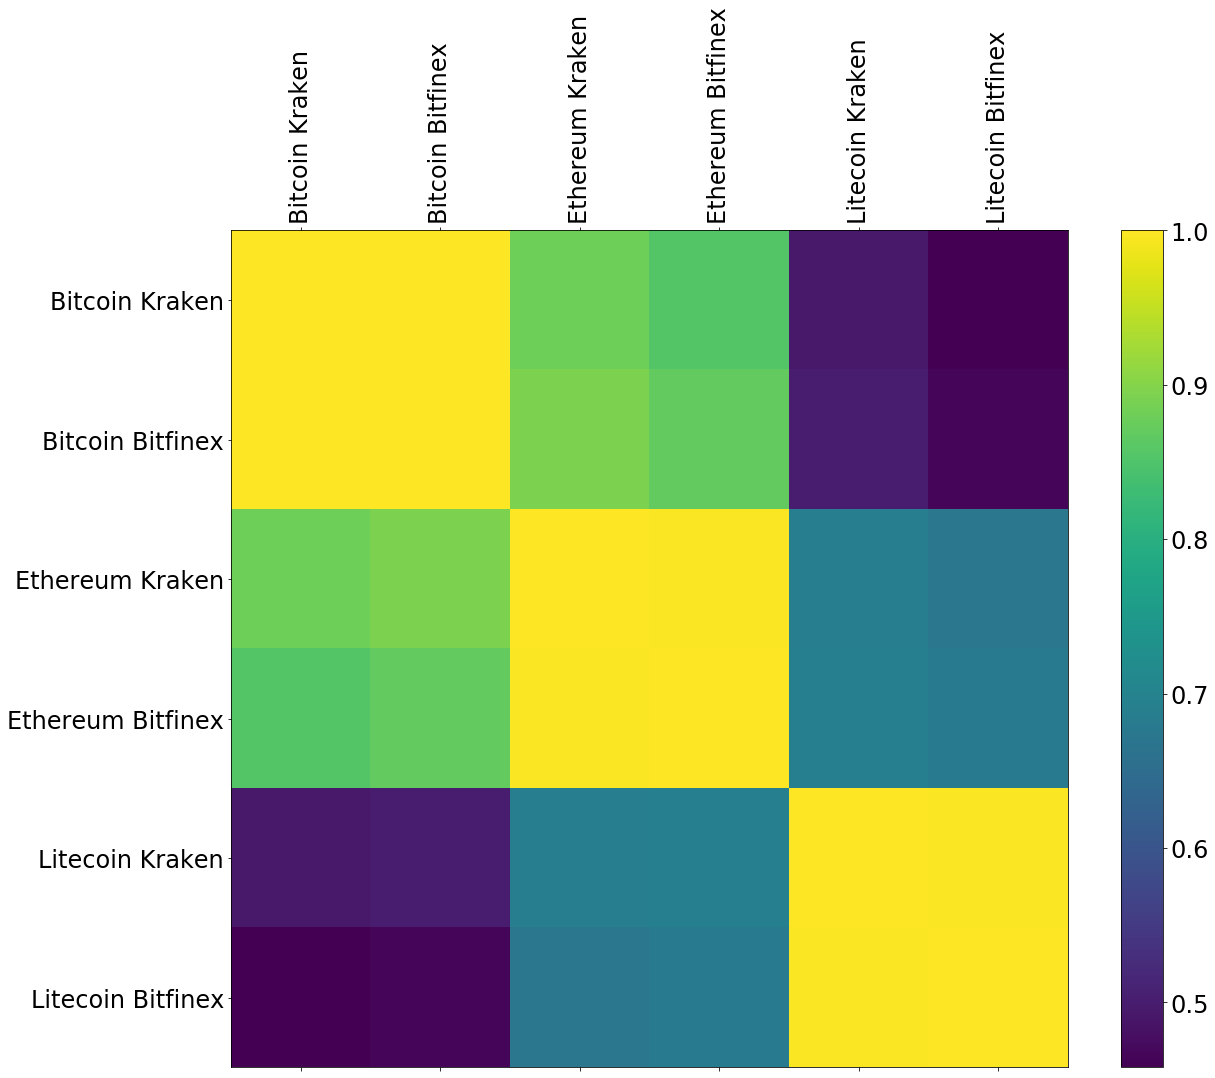

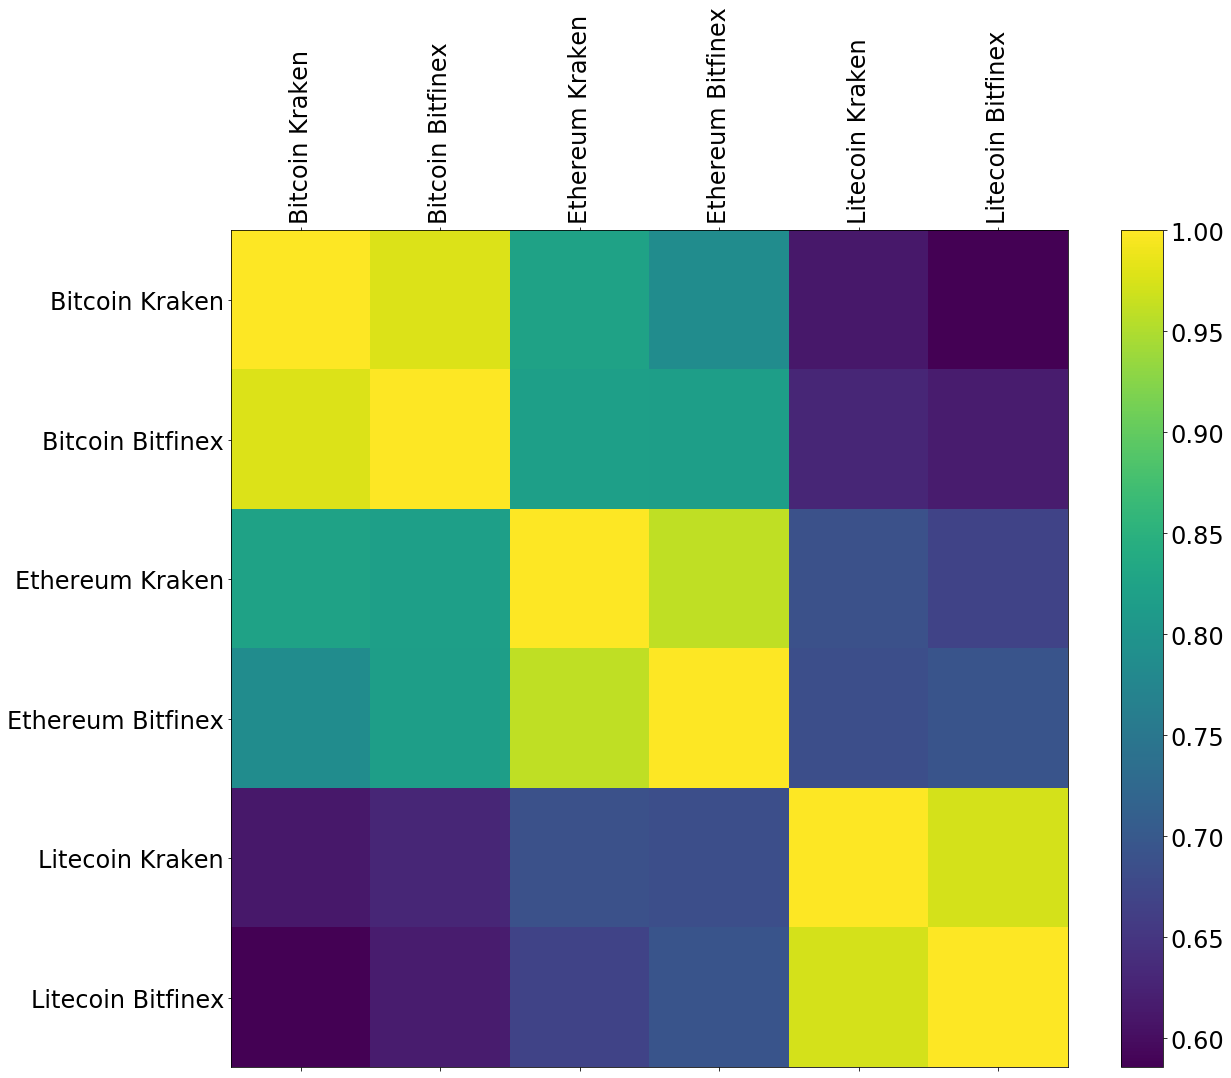

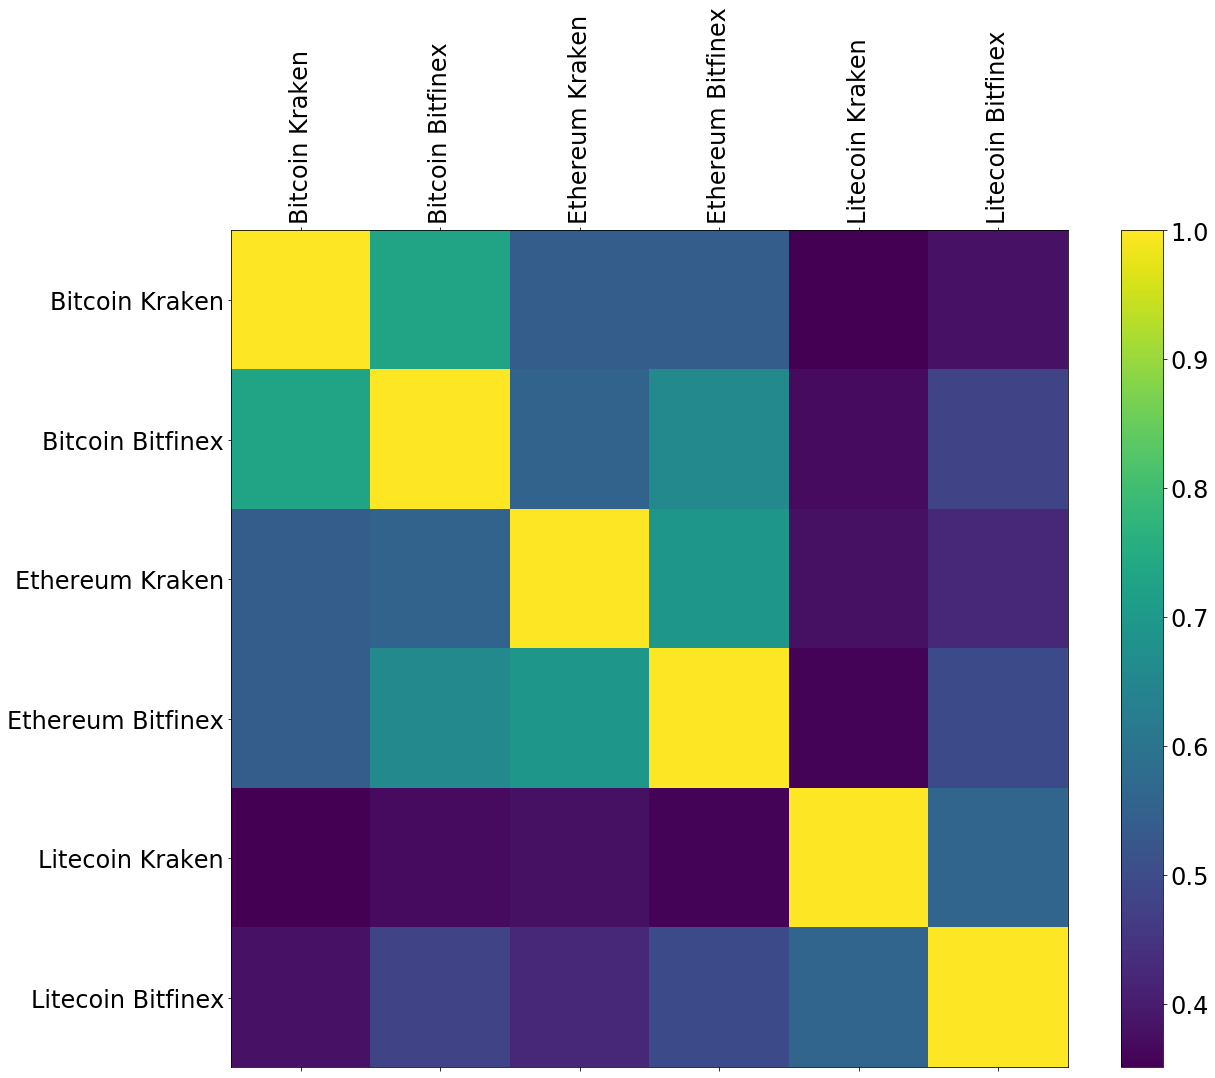

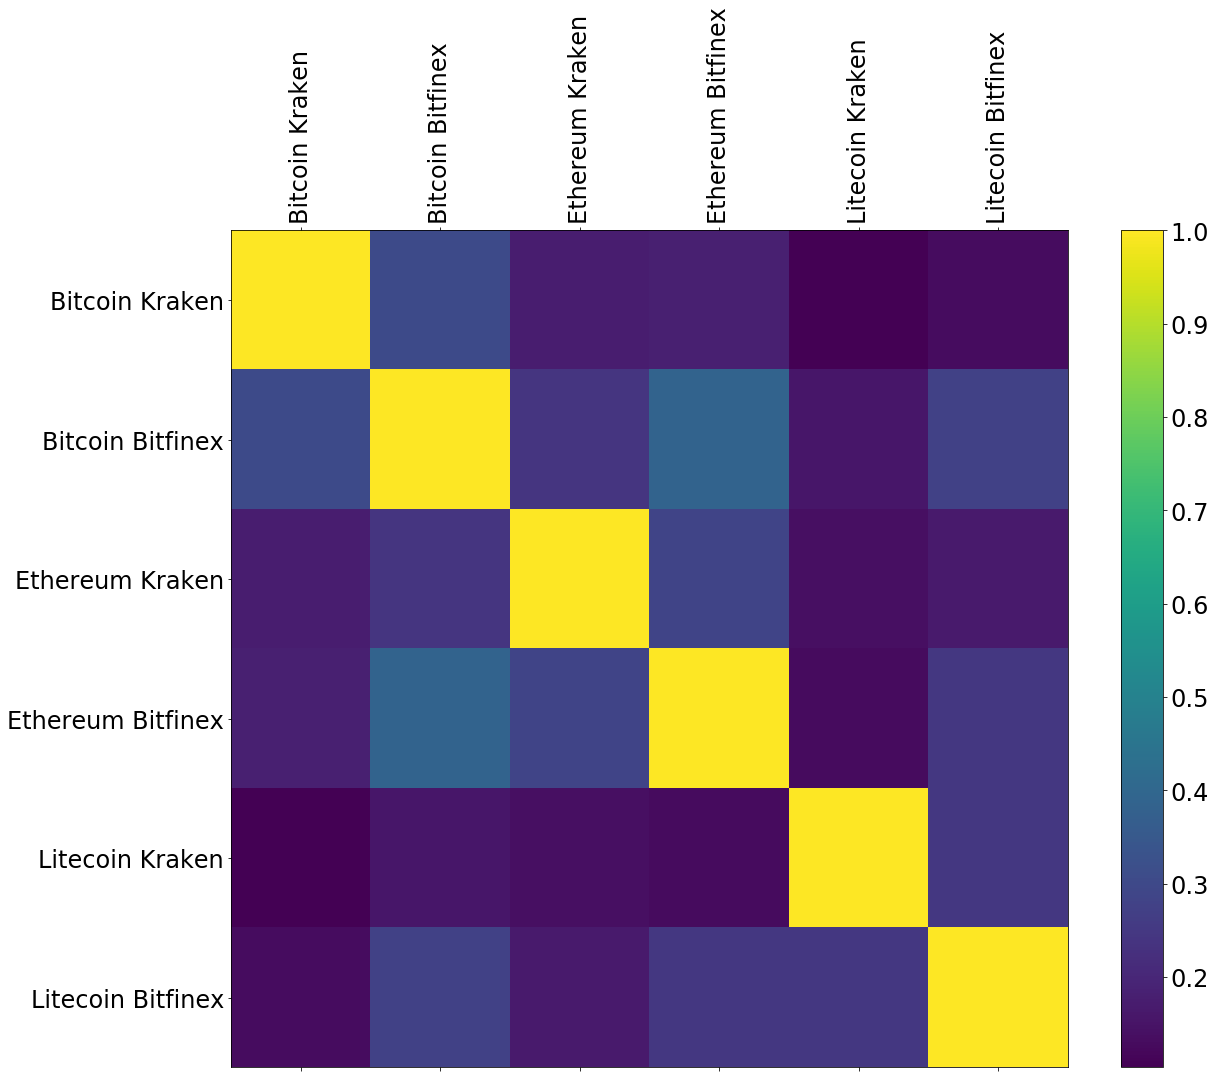

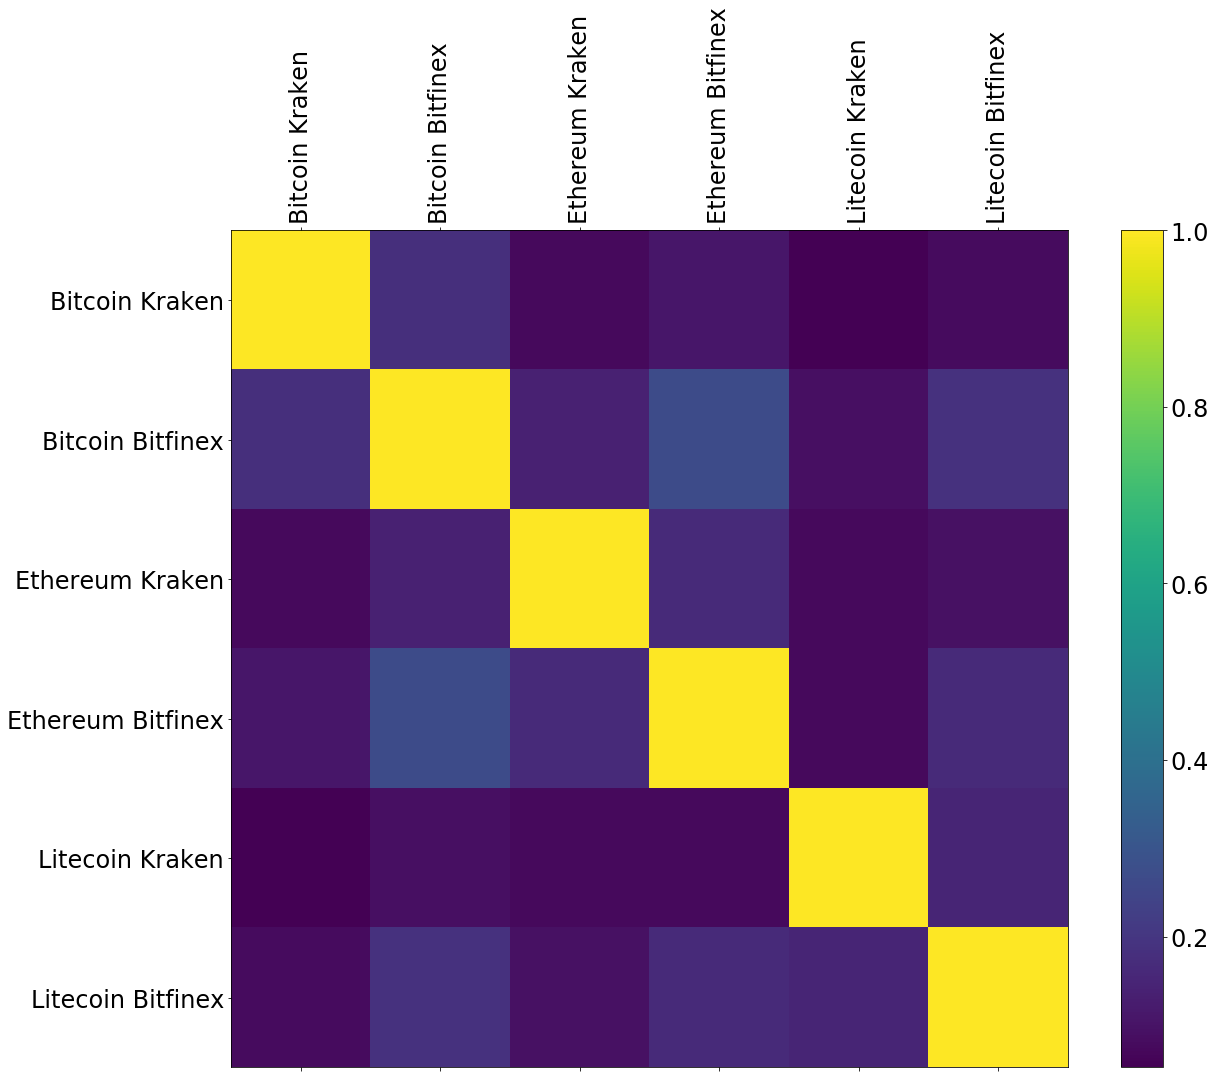

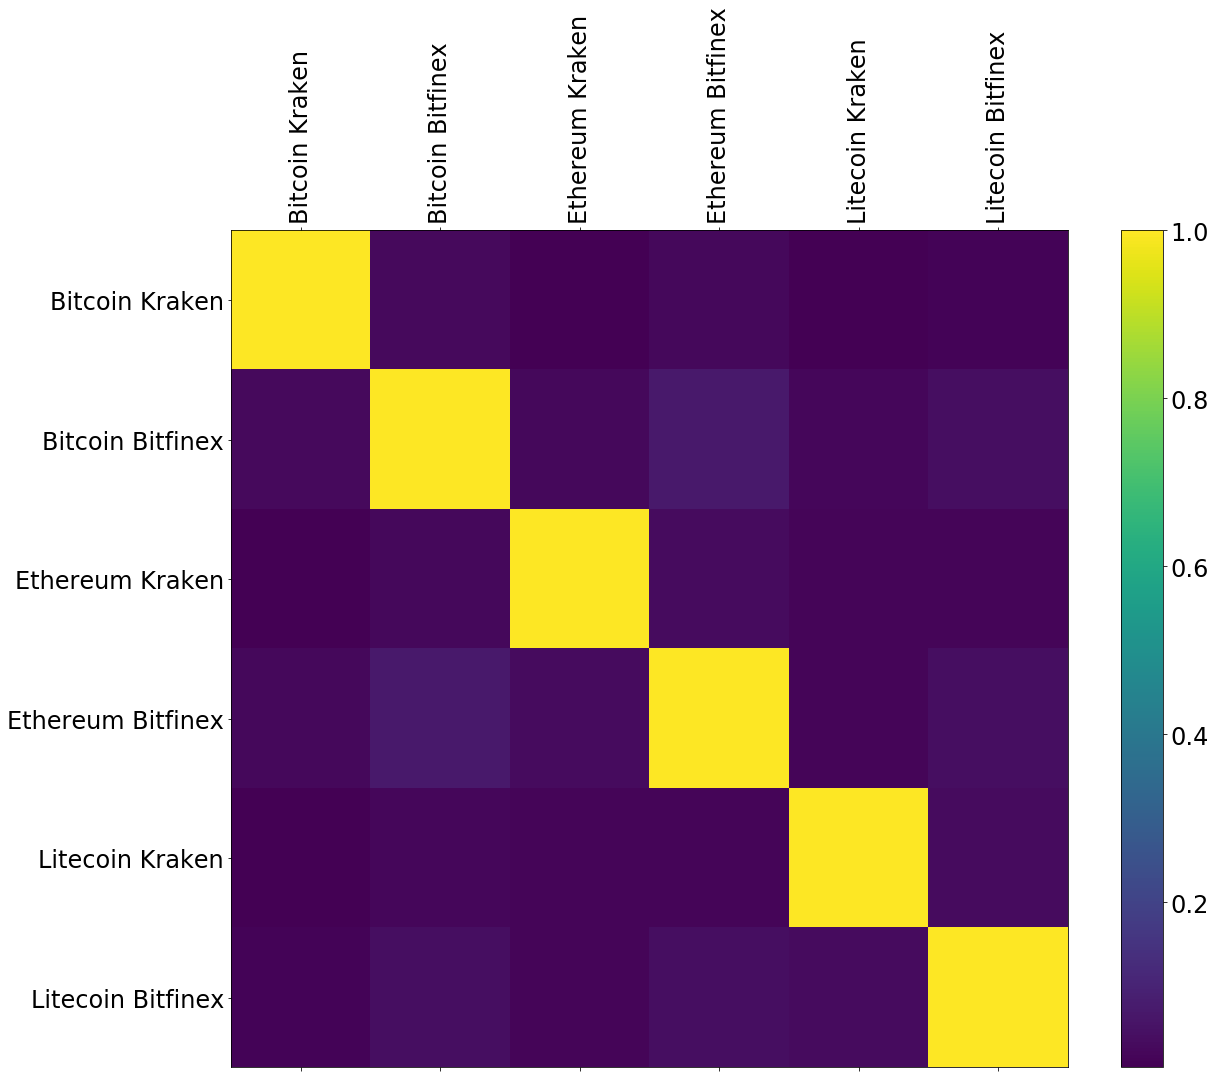

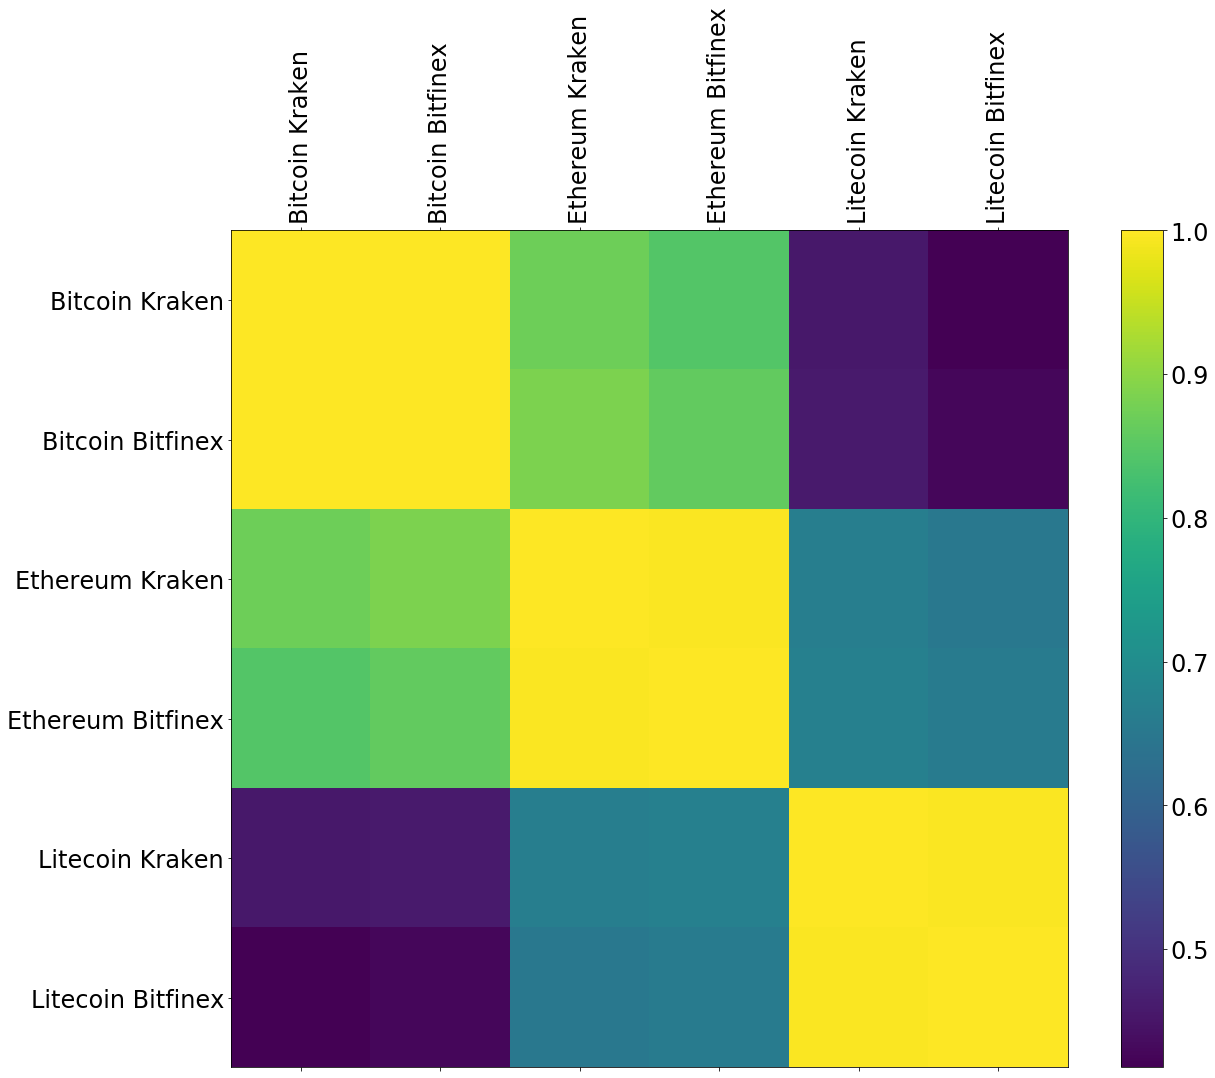

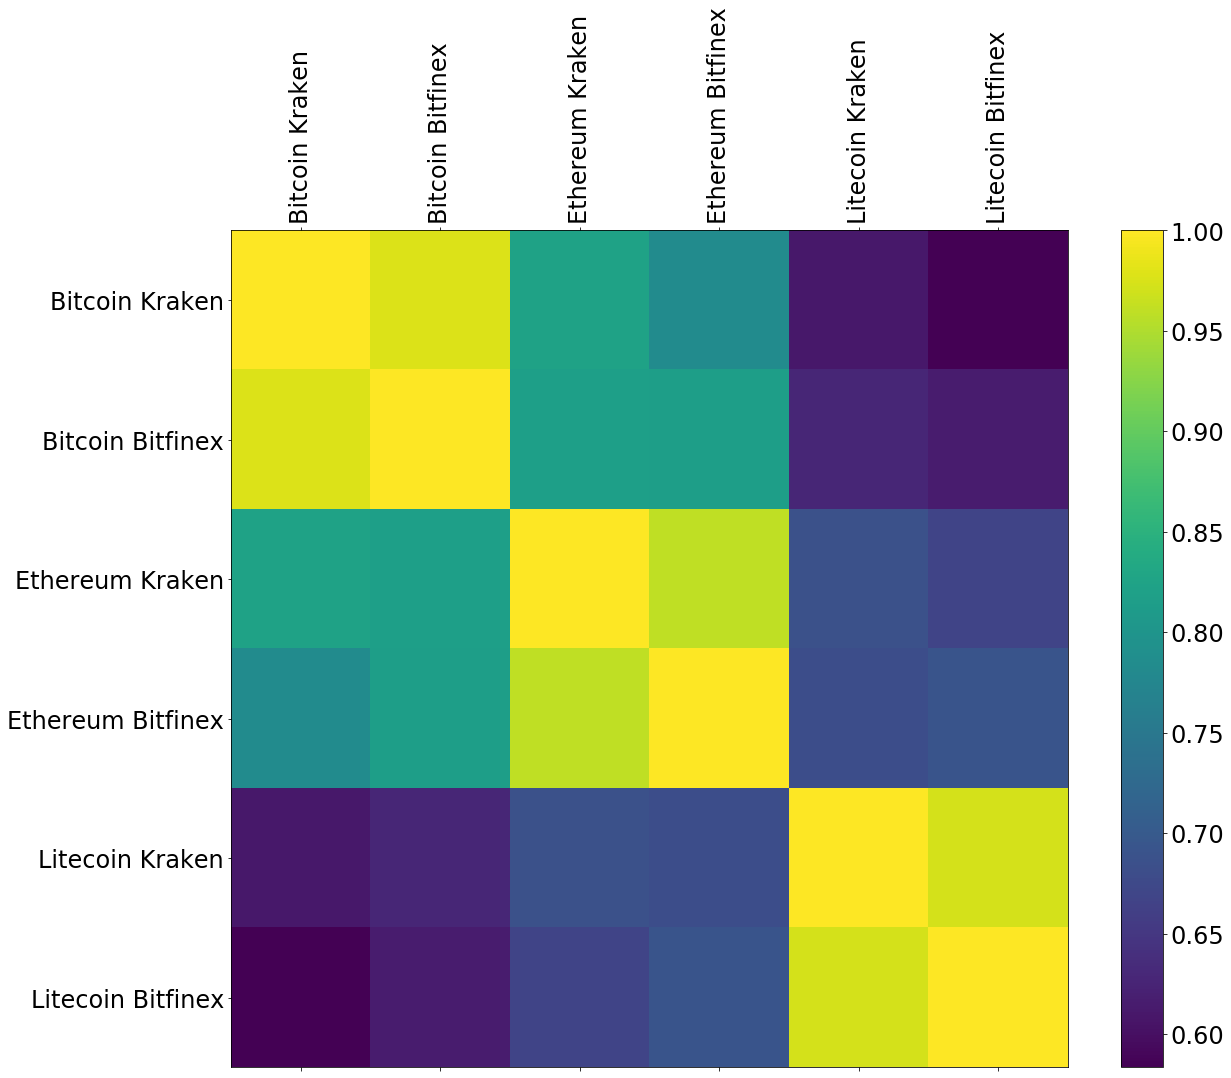

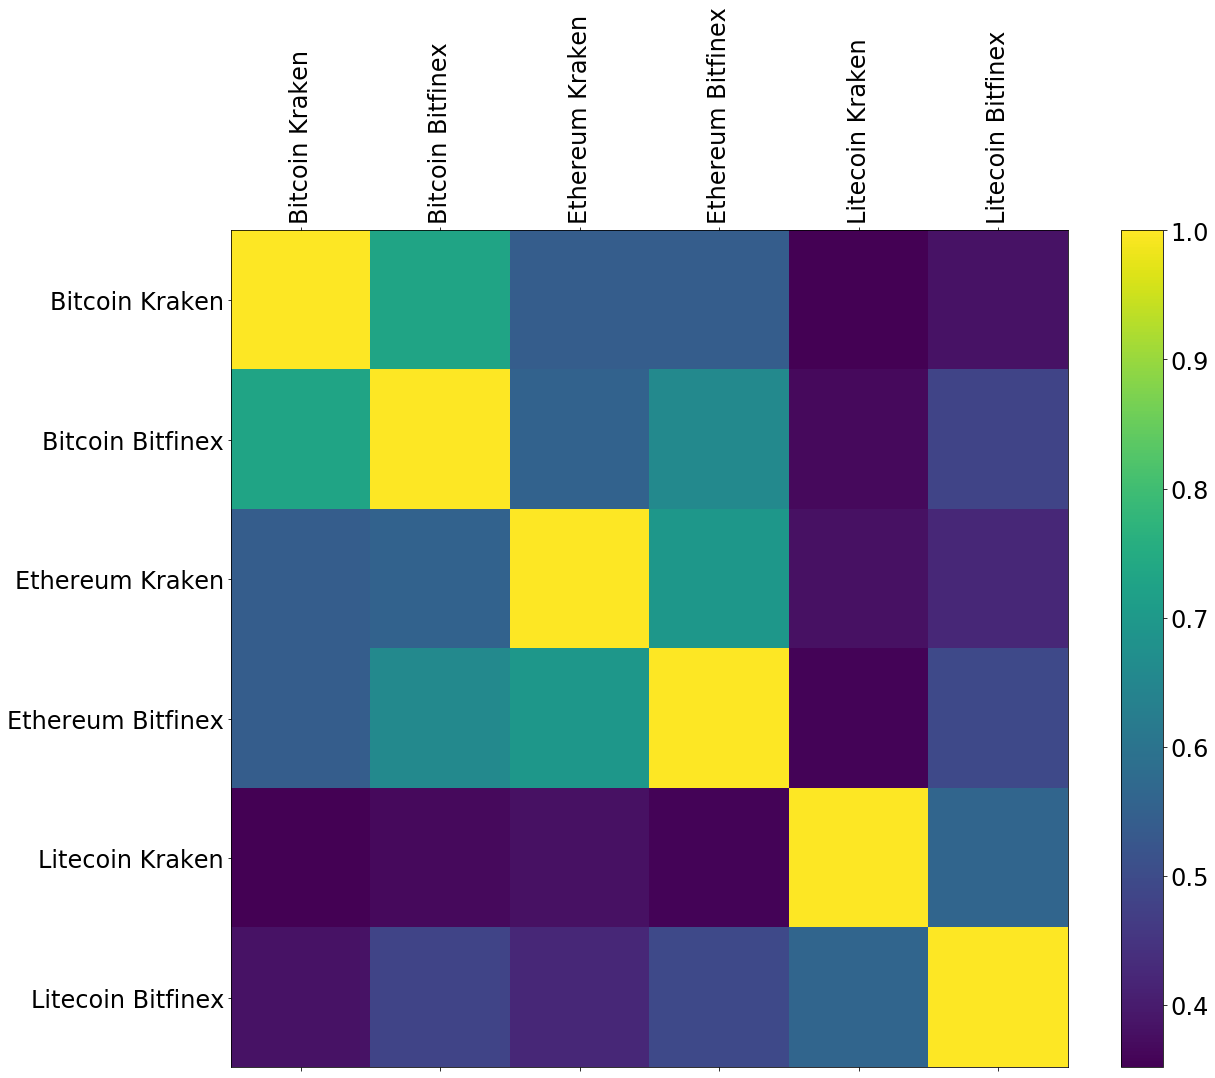

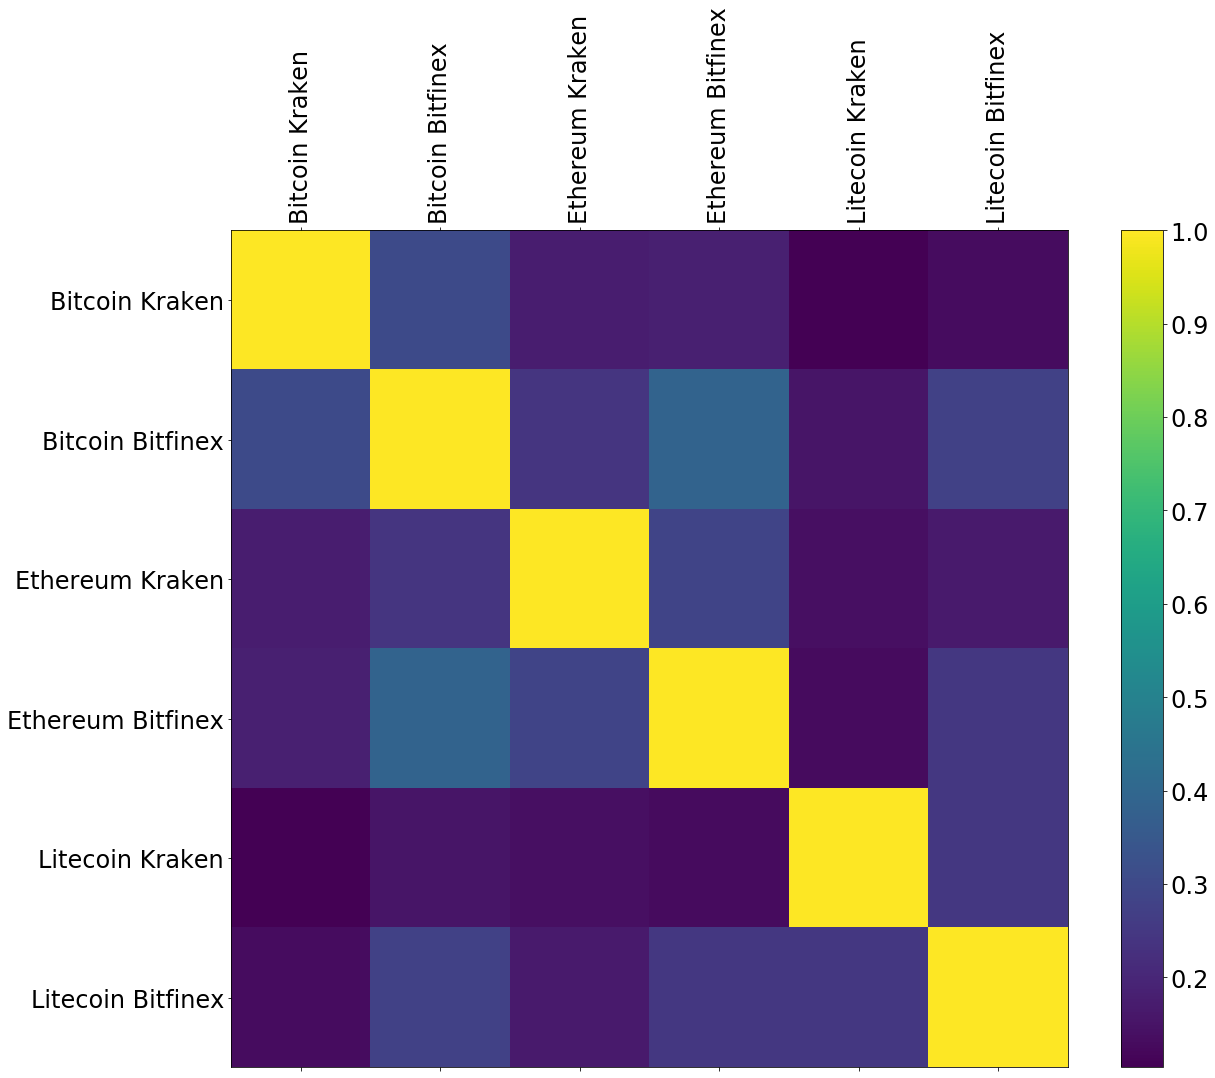

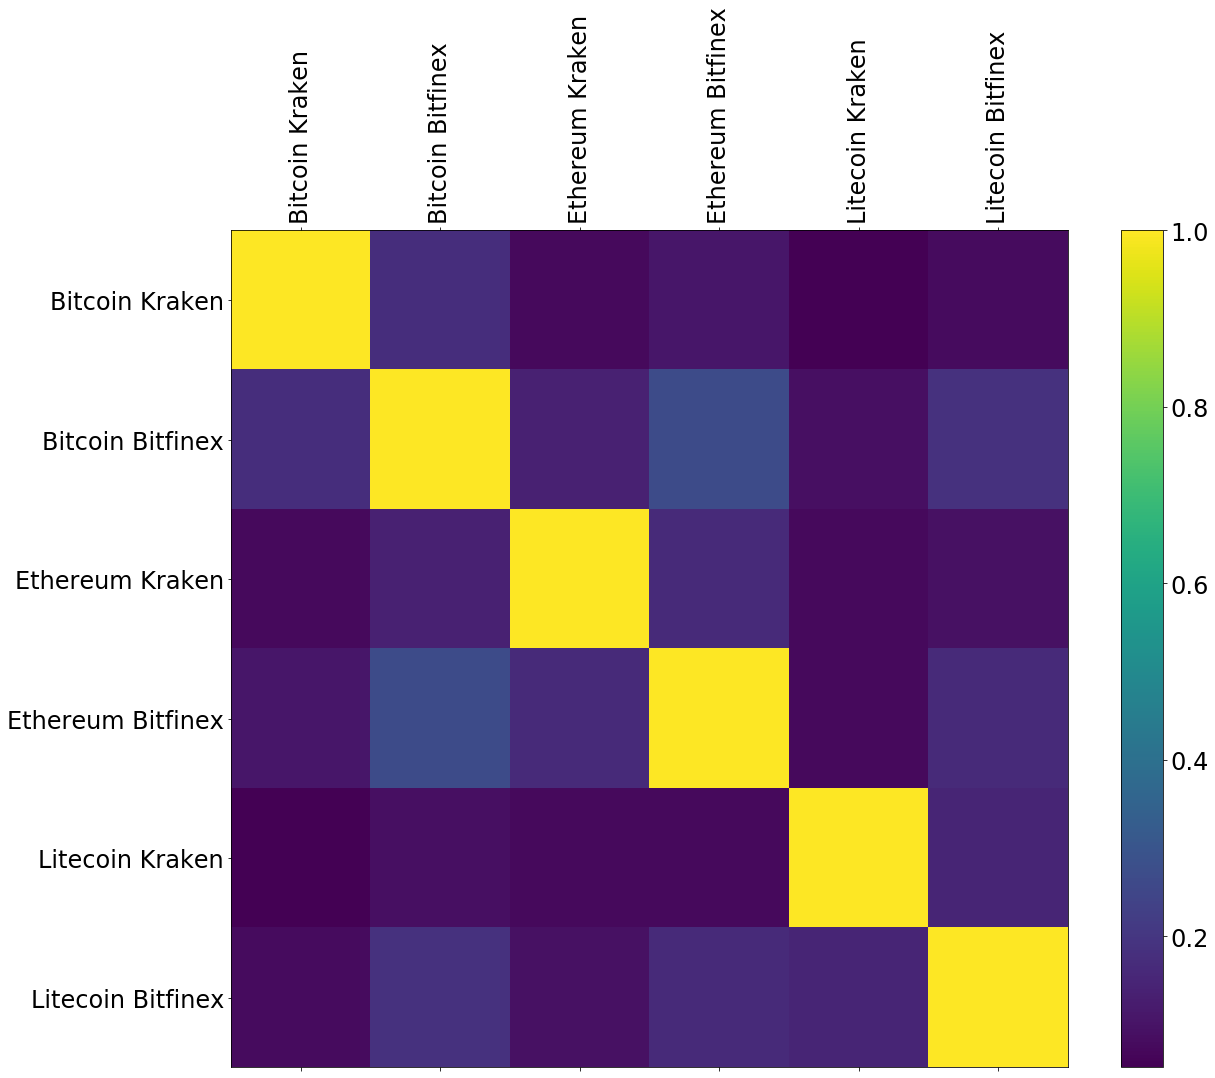

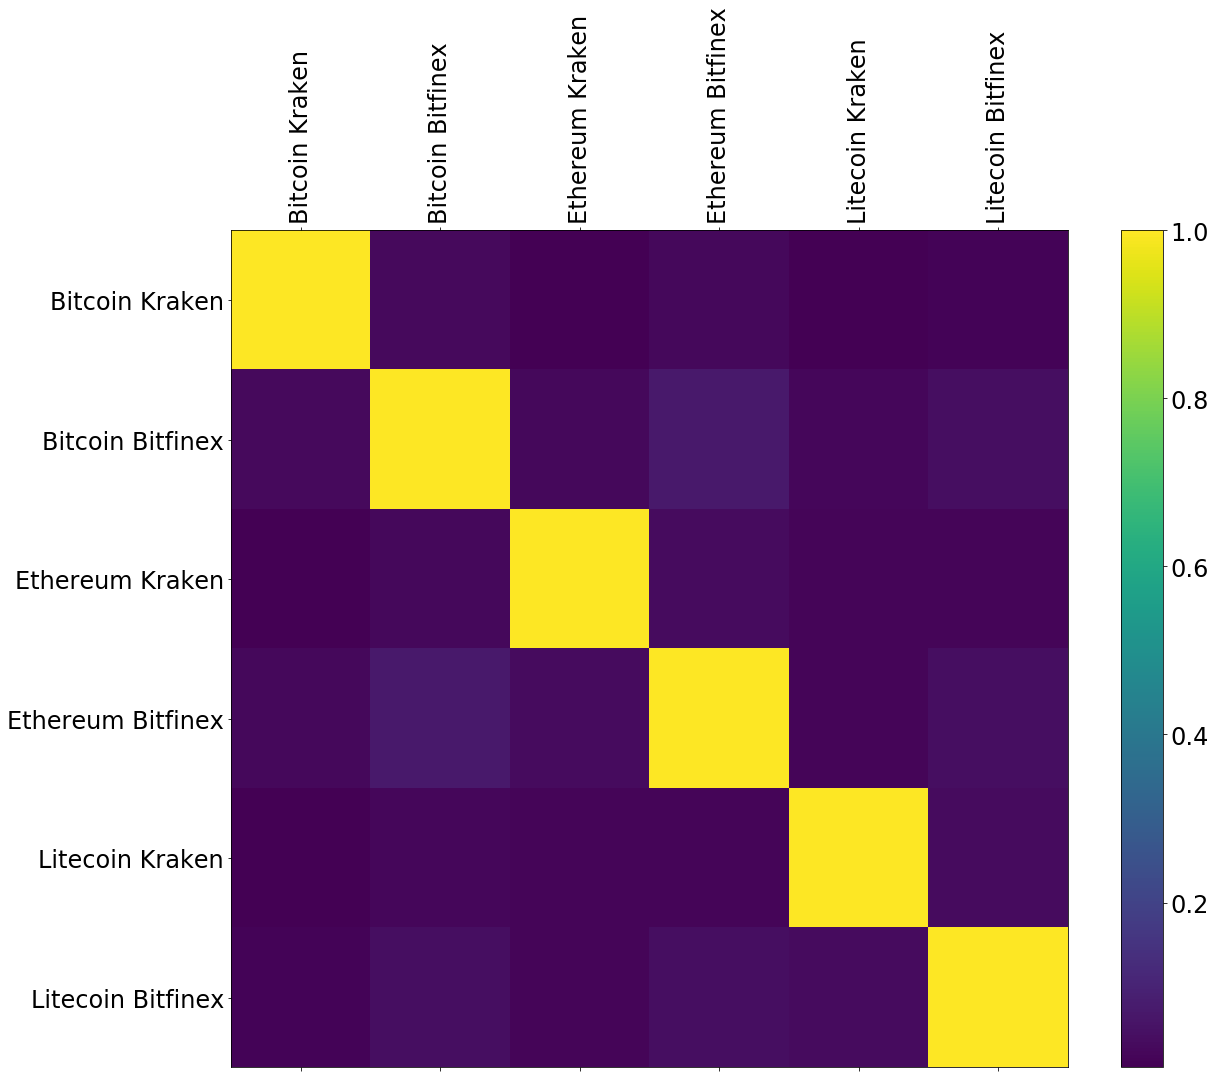

In [11]:
# second, investigate profit and log profit correlation with pearson correlation
#profit
for collectedDataEntry in collectedData:
    plotCorrelation(collectedDataEntry['name'], profit(collectedDataEntry['data']))
#log profit
for collectedDataEntry in collectedData:
    plotCorrelation(collectedDataEntry['name'], logProfit(collectedDataEntry['data']))

In [12]:
# define rolling correlation plot method
def plotRollingCorrelationChange(rollingValue, data):
    f = plt.figure(figsize=(19, 15))
    
    for entry in data:
        plt.plot(entry['firstData'].rolling(rollingValue).corr(entry['secondData'])[rollingValue:], label=entry['label'])
    
    plt.xticks(fontsize=24, rotation=90)
    plt.yticks(fontsize=24)

    plt.xlabel('Time', fontsize=24)
    plt.ylabel('Correlation', fontsize=24)

    plt.legend(fontsize=24)

    plt.show()

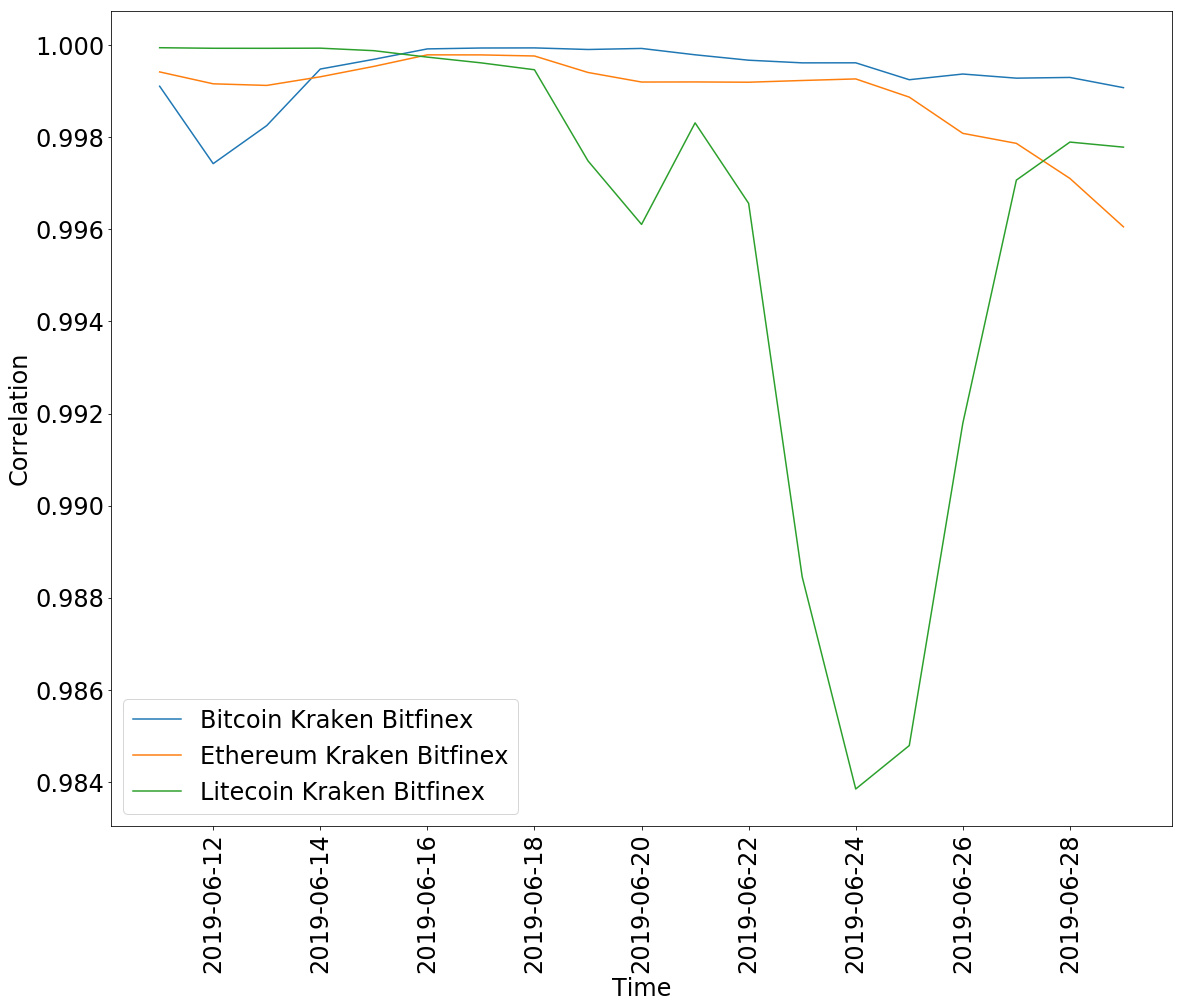

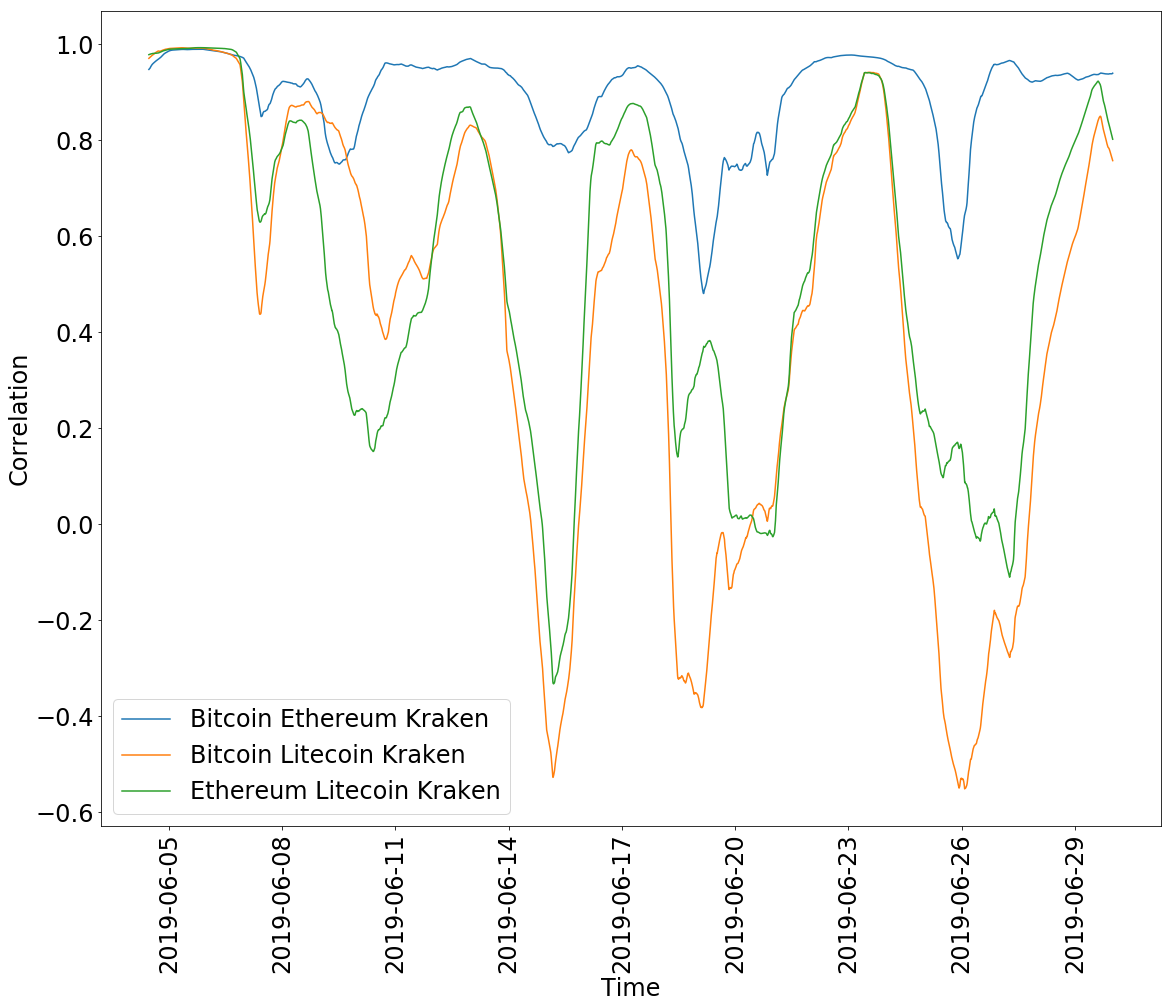

In [24]:
# third, investigate rolling correlation/correlation change
# correlation change of exchanges
plotRollingCorrelationChange(rollingValue=10,data=[
    {'label': 'Bitcoin Kraken Bitfinex', 'firstData': collectedData[0]['data']['Bitcoin Kraken'], 'secondData': collectedData[0]['data']['Bitcoin Bitfinex']},
    {'label': 'Ethereum Kraken Bitfinex', 'firstData': collectedData[0]['data']['Ethereum Kraken'], 'secondData': collectedData[0]['data']['Ethereum Bitfinex']},
    {'label': 'Litecoin Kraken Bitfinex', 'firstData': collectedData[0]['data']['Litecoin Kraken'], 'secondData': collectedData[0]['data']['Litecoin Bitfinex']}
])
# correlation of a selection of some combinations
plotRollingCorrelationChange(rollingValue=5000,data=[
    {'label': 'Bitcoin Ethereum Kraken', 'firstData': collectedData[2]['data']['Bitcoin Kraken'], 'secondData': collectedData[2]['data']['Ethereum Kraken']},
    {'label': 'Bitcoin Litecoin Kraken', 'firstData': collectedData[2]['data']['Bitcoin Kraken'], 'secondData': collectedData[2]['data']['Litecoin Kraken']},
    {'label': 'Ethereum Litecoin Kraken', 'firstData': collectedData[2]['data']['Ethereum Kraken'], 'secondData': collectedData[2]['data']['Litecoin Kraken']}
])

In [14]:
# define plot method for 3d print of shifted correlation
def plotShiftedCorrelation(shiftRange, mainDataSource, comparingDataSources):
    correlations = []
    
    for column in comparingDataSources.columns:
        for forShiftRange in range(math.ceil(-shiftRange / 2), math.ceil(shiftRange / 2), 1):
            correlations.append(mainDataSource.shift(forShiftRange).corr(comparingDataSources[column]))
        
    fig = plt.figure(figsize=(19, 15))
    ax1 = fig.add_subplot(111, projection='3d')
    
    ypos = [x - 0.25 for x in list(range(math.ceil(-shiftRange / 2), math.ceil(shiftRange / 2), 1))] * len(comparingDataSources.columns)
    xpos = [int(x / shiftRange) - 0.025 for x in range(len(correlations))]
    zpos = [0] * len(correlations)

    dy = [0.5] * len(correlations)
    dx = [0.05] * len(correlations)
    dz = correlations

    def format_func(value, tick_number):
        if (value < len(comparingDataSources.columns)):
            return comparingDataSources.columns[int(value)]
        return value

    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

    ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color='#00ceaa')

    ax1.set_ylabel('Time shift')
    ax1.set_zlabel('Correlatioin')

    ax1.view_init(30, 10)

    plt.show()

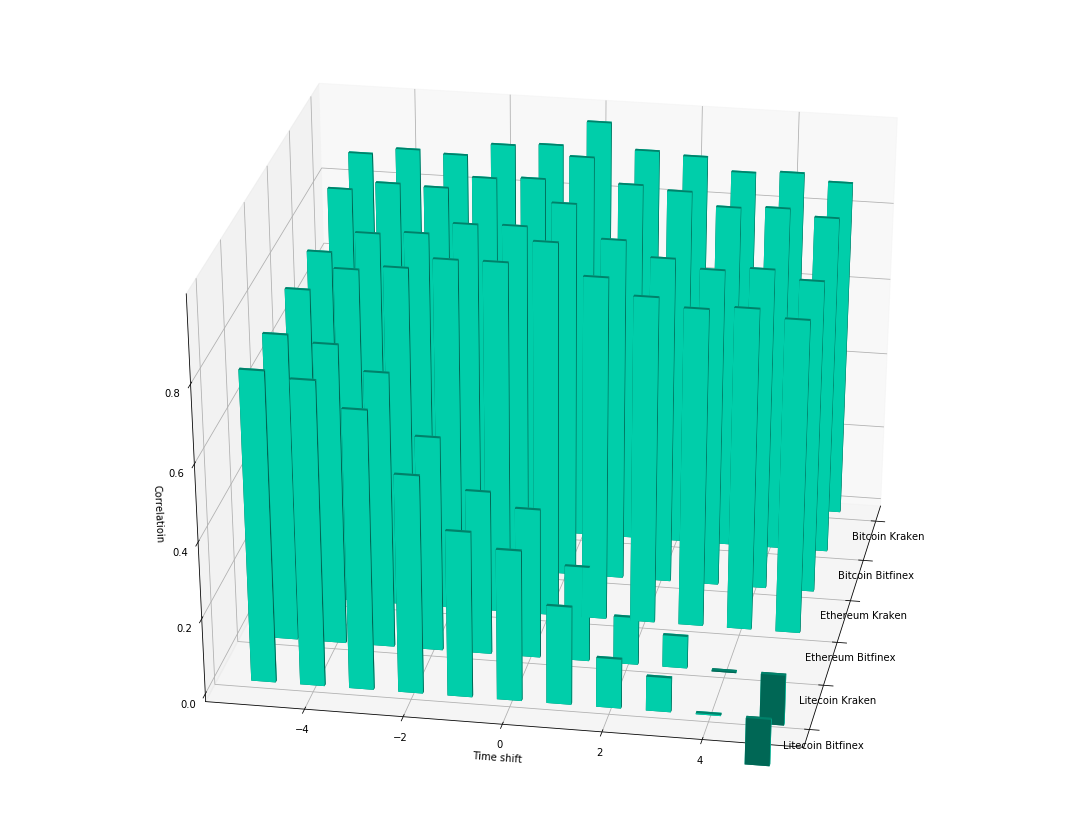

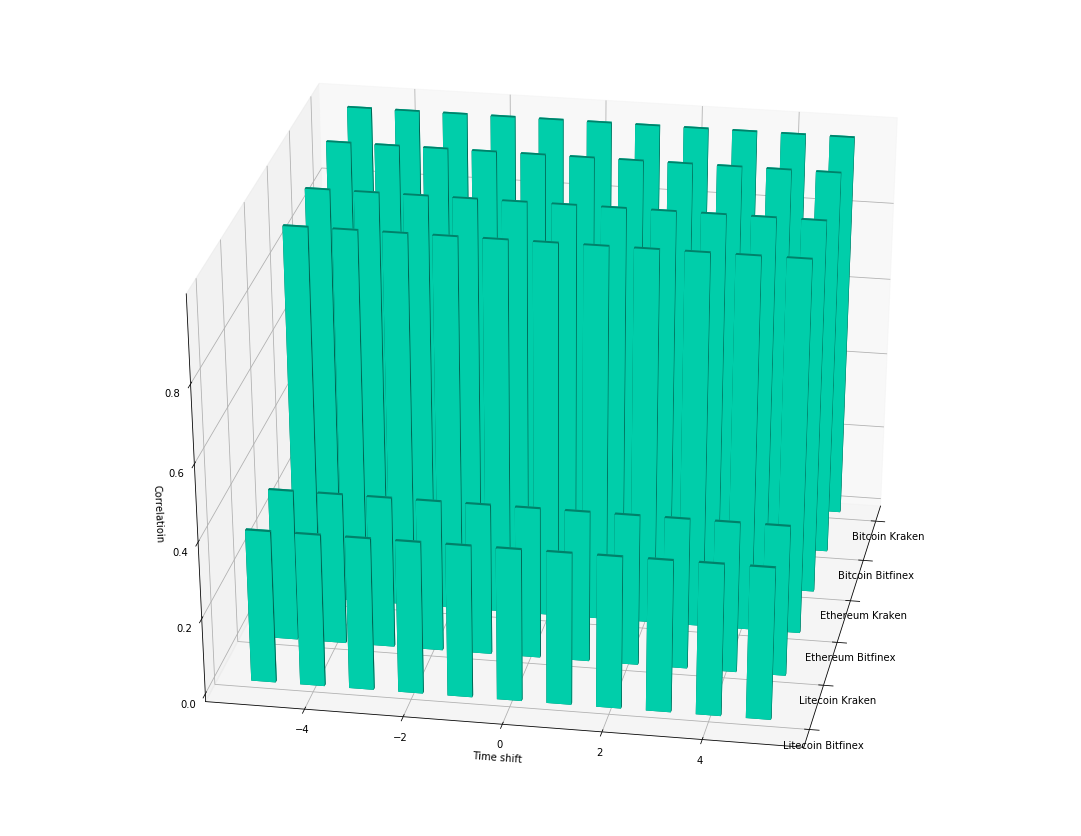

In [15]:
# fourth, investigate correlations in 3d matrix
# dayData
plotShiftedCorrelation(shiftRange=11,mainDataSource=dayData['Bitcoin Kraken'],comparingDataSources=dayData)
# secondData
plotShiftedCorrelation(shiftRange=11,mainDataSource=secondData['Bitcoin Kraken'],comparingDataSources=secondData)

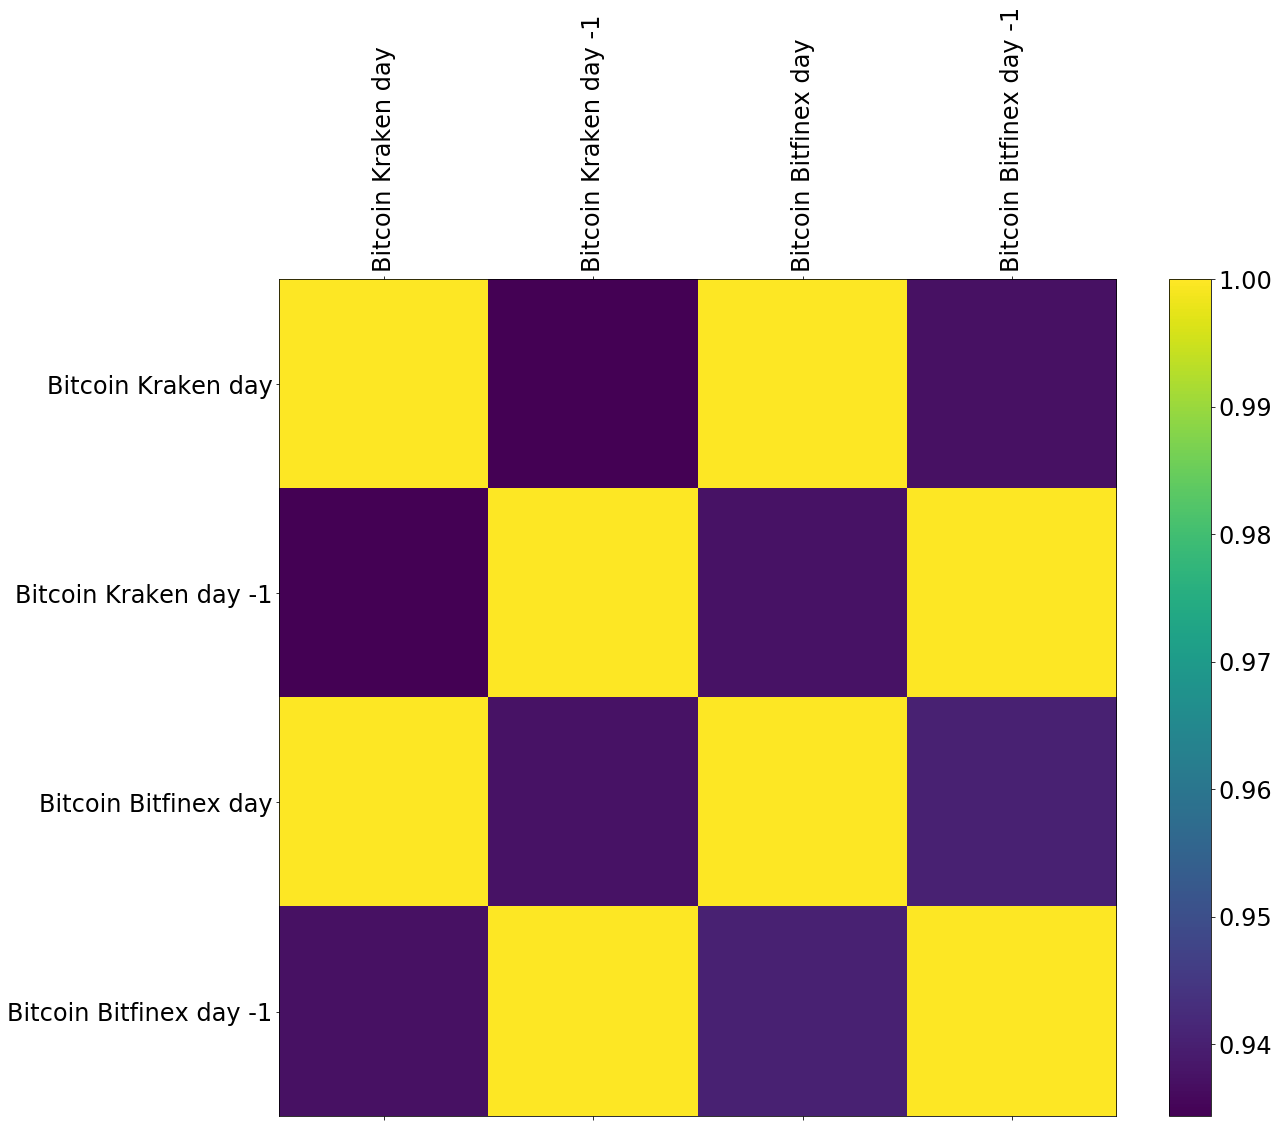

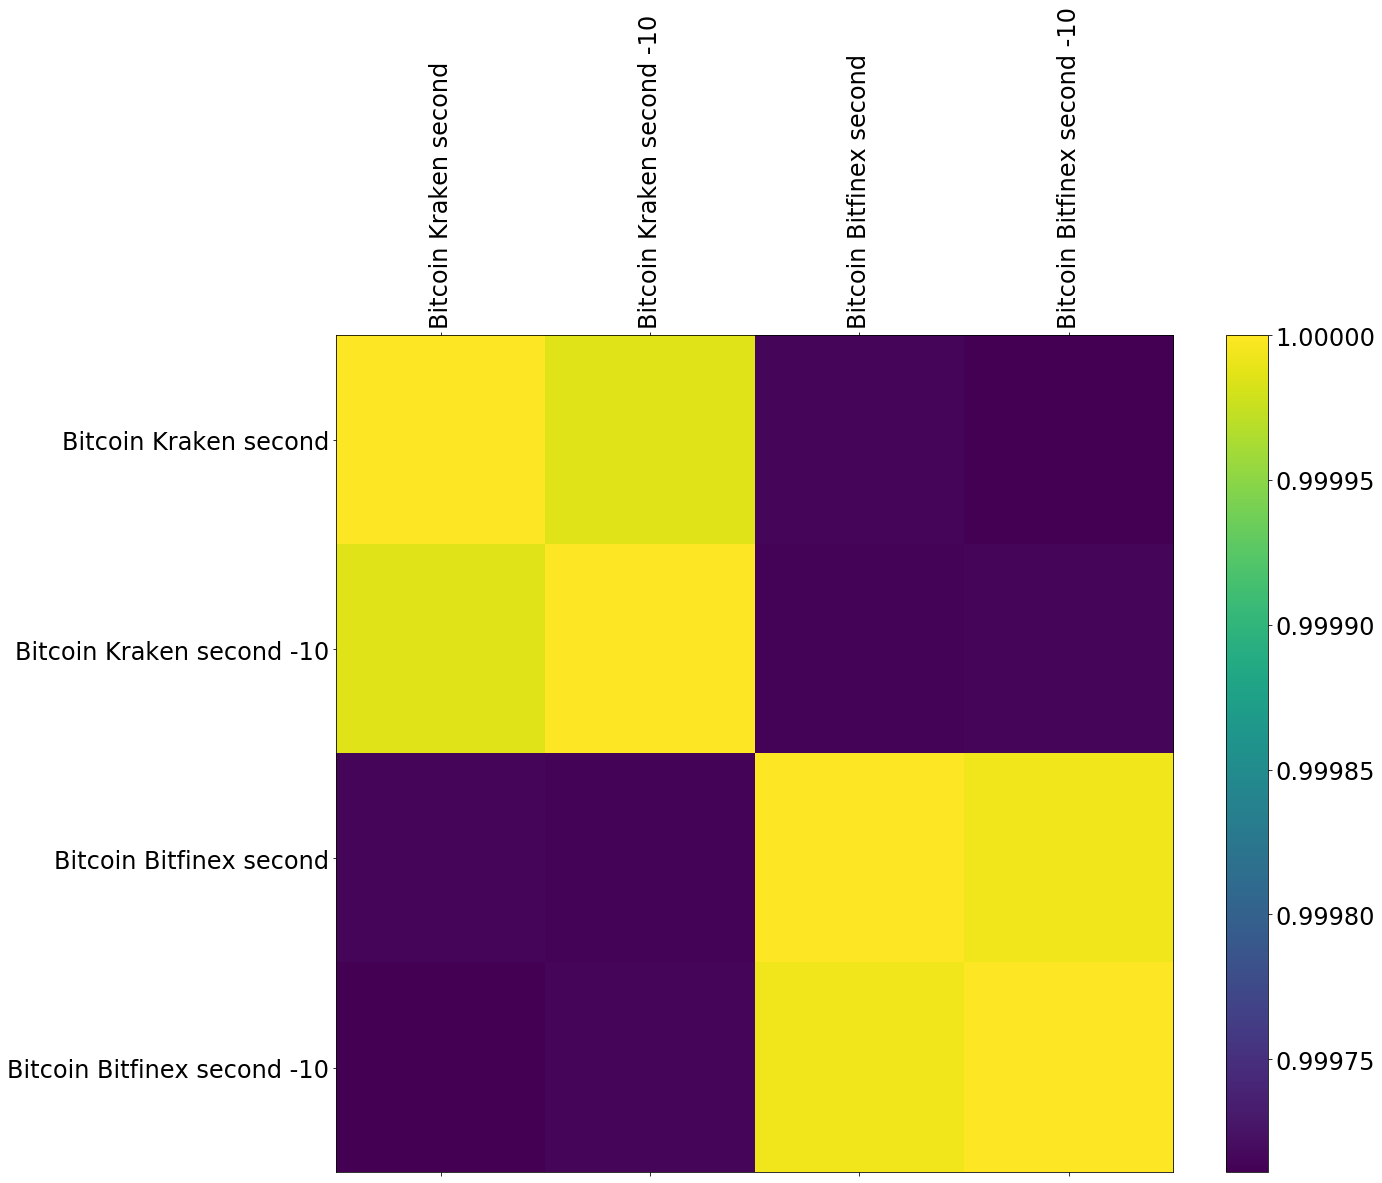

In [25]:
# fifth, compare a selection of shifted correlations

# dayData
selection = pd.DataFrame(np.array([
    collectedData[0]['data']['Bitcoin Kraken'],
    collectedData[0]['data']['Bitcoin Kraken'].shift(-1),
    collectedData[0]['data']['Bitcoin Bitfinex'],
    collectedData[0]['data']['Bitcoin Bitfinex'].shift(-1)
]).transpose(),
columns=[
    'Bitcoin Kraken day',
    'Bitcoin Kraken day -1',
    'Bitcoin Bitfinex day',
    'Bitcoin Bitfinex day -1'
],
index=collectedData[0]['data']['Bitcoin Bitfinex'].index)

f = plt.figure(figsize=(19, 15))
plt.matshow(selection.corr(), fignum=f.number)
plt.xticks(range(selection.shape[1]), selection.columns, fontsize=24, rotation=90)
plt.yticks(range(selection.shape[1]), selection.columns, fontsize=24)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=24)

# secondData
selection = pd.DataFrame(np.array([
    collectedData[5]['data']['Bitcoin Kraken'],
    collectedData[5]['data']['Bitcoin Kraken'].shift(-10),
    collectedData[5]['data']['Bitcoin Bitfinex'],
    collectedData[5]['data']['Bitcoin Bitfinex'].shift(-10)
]).transpose(),
columns=[
    'Bitcoin Kraken second',
    'Bitcoin Kraken second -10',
    'Bitcoin Bitfinex second',
    'Bitcoin Bitfinex second -10'
],
index=collectedData[5]['data']['Bitcoin Bitfinex'].index)

f = plt.figure(figsize=(19, 15))
plt.matshow(selection.corr(), fignum=f.number)
plt.xticks(range(selection.shape[1]), selection.columns, fontsize=24, rotation=90)
plt.yticks(range(selection.shape[1]), selection.columns, fontsize=24)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=24)

In [138]:
dollar = 100
crypto = 0

def simulateMovingAverage(tradingData, signalData, movingAverageWindow):
    global dollar
    global crypto
    
    dollar = 100
    crypto = 0
    
    profitGraph = pd.DataFrame([], columns=['profit'], index=tradingData.index)

    rollingSignalBoolean = signalData > signalData.rolling(movingAverageWindow).mean()
    rollingSignalInt = 1 * rollingSignalBoolean
    rollingSignalStep = rollingSignalInt - rollingSignalInt.shift(1)

    combinedDataFrame = pd.DataFrame(index=tradingData.index)
    combinedDataFrame['tradingData'] = tradingData
    combinedDataFrame['rollingSignalStep'] = rollingSignalStep
    combinedDataFrame['profit'] = dollar
    
    combinedDataFrame = combinedDataFrame[combinedDataFrame['rollingSignalStep'] != 0]
    
    def simulateTrading(row):
        clear_output(wait=True)
        print(row)
        
        global dollar
        global crypto

        print(dollar)
        print(crypto)
        
        if (row['rollingSignalStep'] > 0 and dollar != 0):
            crypto = dollar / row['tradingData'] * 0.995
            dollar = 0

        if (row['rollingSignalStep'] < 0 and crypto != 0):
            dollar = row['tradingData'] * crypto * 0.995
            crypto = 0

        return row
    
    combinedDataFrame = combinedDataFrame.apply(lambda row: simulateTrading(row), axis=1)
    
    print(dollar + crypto * tradingData[-1])

In [139]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'], 100)

tradingData          11931.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:31, dtype: float64
0
5.5992362111e-96
6.64738075424e-92


In [140]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(1), 100)

tradingData          11931.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:32, dtype: float64
0
3.2976980211e-96
3.915007964e-92


In [141]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(-1), 100)

tradingData          11931.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:30, dtype: float64
0
9.57132522049e-96
1.13630217881e-91


In [142]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'], 1000)

tradingData          11931.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:31, dtype: float64
0
4.33064127654e-21
5.14131220579e-17


In [143]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(1), 1000)

tradingData          11931.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:32, dtype: float64
0
3.38903915567e-21
4.02344762918e-17


In [144]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(-1), 1000)

tradingData          11931.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:30, dtype: float64
0
5.30777583619e-21
6.30136068762e-17


In [152]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'], 86400)

tradingData          11833.9
rollingSignalStep        1.0
profit                 100.0
Name: 2019-06-29 23:58:45, dtype: float64
0.825018773945
0
0.822398965135


In [153]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(1), 86400)

tradingData          11843.2
rollingSignalStep        1.0
profit                 100.0
Name: 2019-06-29 23:58:46, dtype: float64
0.777879870339
0
0.774800850094


In [154]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(-1), 86400)

tradingData          11855.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:58:59, dtype: float64
0
7.21253858482e-05
0.85081427584


In [167]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'], 259200)

tradingData          11851.8
rollingSignalStep        1.0
profit                 100.0
Name: 2019-06-29 17:50:31, dtype: float64
16.6818746335
0
16.6037871665


In [168]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(1), 259200)

tradingData          11851.8
rollingSignalStep        1.0
profit                 100.0
Name: 2019-06-29 17:50:32, dtype: float64
16.0024688908
0
15.9275617063


In [169]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(-1), 259200)

tradingData          11855.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:58:59, dtype: float64
0
0.0014058276264
16.5835953575


In [170]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'], 604800)

tradingData          11446.0
rollingSignalStep        1.0
profit                 100.0
Name: 2019-06-29 06:07:45, dtype: float64
53.6718056104
0
55.3145117335


In [171]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(1), 604800)

tradingData          11446.0
rollingSignalStep        1.0
profit                 100.0
Name: 2019-06-29 06:07:46, dtype: float64
52.0141147961
0
53.6060848052


In [172]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Bitcoin Bitfinex'].shift(-1), 604800)

tradingData          11855.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:58:59, dtype: float64
0
0.00472414475203
55.7275326696


In [145]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Bitcoin Bitfinex'], 100)

tradingData          11931.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:30, dtype: float64
0
2.00667004955e-25
2.38230704413e-21


In [146]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Bitcoin Bitfinex'].shift(1), 100)

tradingData          11930.1
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:35, dtype: float64
0
7.6426857142e-26
9.07221148148e-22


In [147]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Bitcoin Bitfinex'].shift(-1), 100)

tradingData          11931.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:25, dtype: float64
0
6.68330128684e-25
7.93437652458e-21


In [148]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Bitcoin Bitfinex'], 1000)

tradingData          12013.4
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:30:55, dtype: float64
0
3.32512745377e-09
3.97463557223e-05


In [149]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Bitcoin Bitfinex'].shift(1), 1000)

tradingData          12005.8
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:31:00, dtype: float64
0
2.24789302785e-09
2.68528153432e-05


In [150]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Bitcoin Bitfinex'].shift(-1), 1000)

tradingData          12013.4
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:30:50, dtype: float64
0
5.24302088725e-09
6.26715745913e-05


In [155]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Ethereum Kraken'], 100)

tradingData          11952.9
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:55:43, dtype: float64
0
1.41101089565e-66
1.6781343774e-62


In [156]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Ethereum Kraken'].shift(1), 100)

tradingData          11952.9
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:55:44, dtype: float64
0
1.05995382959e-66
1.26061745191e-62


In [157]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Ethereum Kraken'].shift(-1), 100)

tradingData          11952.9
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:55:42, dtype: float64
0
2.07884997998e-66
2.47240444961e-62


In [158]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Ethereum Kraken'], 1000)

tradingData          11944.7
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:02, dtype: float64
0
7.48733381386e-19
8.89867864253e-15


In [159]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Ethereum Kraken'].shift(1), 1000)

tradingData          11944.7
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:03, dtype: float64
0
6.72888959573e-19
7.99726947163e-15


In [160]:
simulateMovingAverage(secondData['Bitcoin Kraken'], secondData['Ethereum Kraken'].shift(-1), 1000)

tradingData          11944.7
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:57:01, dtype: float64
0
8.54820150533e-19
1.01595174008e-14


In [161]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Ethereum Kraken'], 100)

tradingData          11952.9
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:55:40, dtype: float64
0
8.11226669384e-25
9.64802870019e-21


In [162]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Ethereum Kraken'].shift(1), 100)

tradingData          11959.8
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:55:45, dtype: float64
0
4.74796319043e-25
5.65007667141e-21


In [163]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Ethereum Kraken'].shift(-1), 100)

tradingData          11952.9
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:55:35, dtype: float64
0
1.92122984612e-24
2.28494468866e-20


In [164]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Ethereum Kraken'], 1000)

tradingData          12021.4
rollingSignalStep        1.0
profit                 100.0
Name: 2019-06-29 22:22:00, dtype: float64
2.56593640643e-05
0
2.51789409568e-05


In [165]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Ethereum Kraken'].shift(1), 1000)

tradingData          12021.4
rollingSignalStep        1.0
profit                 100.0
Name: 2019-06-29 22:22:05, dtype: float64
2.09949539523e-05
0
2.06018631105e-05


In [166]:
simulateMovingAverage(fiveSecondData['Bitcoin Kraken'], fiveSecondData['Ethereum Kraken'].shift(-1), 1000)

tradingData          11855.6
rollingSignalStep       -1.0
profit                 100.0
Name: 2019-06-29 23:58:55, dtype: float64
0
2.90752025507e-09
3.42980451503e-05
